In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import time

# Paths and stuff
import os
import sys

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
surfvel_data_40kms = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/surfvel_data_40kms.nc")
vx_uncert_data = surfvel_data_40kms["vx_uncert"].data
vy_uncert_data = surfvel_data_40kms["vy_uncert"].data

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")

zs_data = H_data_40["zs"].data
mask_zs = zs_data >= -50.0
mask_zs = mask_zs.astype(float)

In [3]:
sicopolis_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS_mini'
simulation = 'grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp'
dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(12, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1

log_c_slide_init = np.log10(8.5)*np.ones((JMAX+1, IMAX+1))
log_p_weert = np.log10(3.0)
log_q_weert = np.log10(2.0)
log_enh_fact_da_dummy2d_scalar = np.log10(3.0)
log_enh_intg_da_dummy2d_scalar = np.log10(1.0)

# Ensure the sequence in these arrays is the same as defined in ad_specs.h
dict_og_params_fields_vals = {"xx_c_slide_init": log_c_slide_init,
                              "xx_p_weert": log_p_weert,
                              "xx_q_weert": log_q_weert,
                              "xx_enh_fact_da_dummy2d_scalar": log_enh_fact_da_dummy2d_scalar,
                              "xx_enh_intg_da_dummy2d_scalar": log_enh_intg_da_dummy2d_scalar}
dict_params_fields_num_dims = {"xx_c_slide_init": "2D",
                               "xx_p_weert": "2D",
                               "xx_q_weert": "2D",
                               "xx_enh_fact_da_dummy2d_scalar": "2D",
                               "xx_enh_intg_da_dummy2d_scalar": "2D"}
dict_params_coords = {"time_ad": time_ad,
                      "zeta_c": exp_sigma_level,
                      "y": yModel40,
                      "x": xModel40}
dict_params_attrs_type = {"xx_c_slide_init": "nodiff",
                          "xx_p_weert": "nodiff",
                          "xx_q_weert": "nodiff",
                          "xx_enh_fact_da_dummy2d_scalar": "nodiff",
                          "xx_enh_intg_da_dummy2d_scalar": "nodiff"}
dict_params_fields_or_scalars = {"xx_c_slide_init": "field",
                                 "xx_p_weert": "scalar",
                                 "xx_q_weert": "scalar",
                                 "xx_enh_fact_da_dummy2d_scalar": "scalar",
                                 "xx_enh_intg_da_dummy2d_scalar": "scalar"}

year2sec = 3.1556925445e+07
sec2year = 1/year2sec
dict_masks_observables = {"vx_s_g": mask_zs*(vx_uncert_data*sec2year)**(-2),
                          "vy_s_g": mask_zs*(vy_uncert_data*sec2year)**(-2)}

dict_prior_sigmas = {"xx_c_slide_init": 0.3,
                     "xx_p_weert": 0.3,
                     "xx_q_weert": 0.3,
                     "xx_enh_fact_da_dummy2d_scalar": 0.3,
                     "xx_enh_intg_da_dummy2d_scalar": 0.3}
dict_prior_gammas = {"xx_c_slide_init": 1.0,
                     "xx_p_weert": 0.0,
                     "xx_q_weert": 0.0,
                     "xx_enh_fact_da_dummy2d_scalar": 0.0,
                     "xx_enh_intg_da_dummy2d_scalar": 0.0}
dict_prior_deltas = {"xx_c_slide_init": 1.e-5,
                     "xx_p_weert": 0.0,
                     "xx_q_weert": 0.0,
                     "xx_enh_fact_da_dummy2d_scalar": 0.0,
                     "xx_enh_intg_da_dummy2d_scalar": 0.0}

list_fields_to_ignore = ["xx_p_weert", "xx_q_weert", "xx_enh_fact_da_dummy2d_scalar", "xx_enh_intg_da_dummy2d_scalar"]

# all_fields = ["xx_c_slide_init",
#               "xx_p_weert", "xx_q_weert",
#               "xx_enh_fact_da_dummy2d_scalar", "xx_enh_intg_da_dummy2d_scalar"]

MAX_ITERS_SOR = 1000
OMEGA_SOR = 1.5

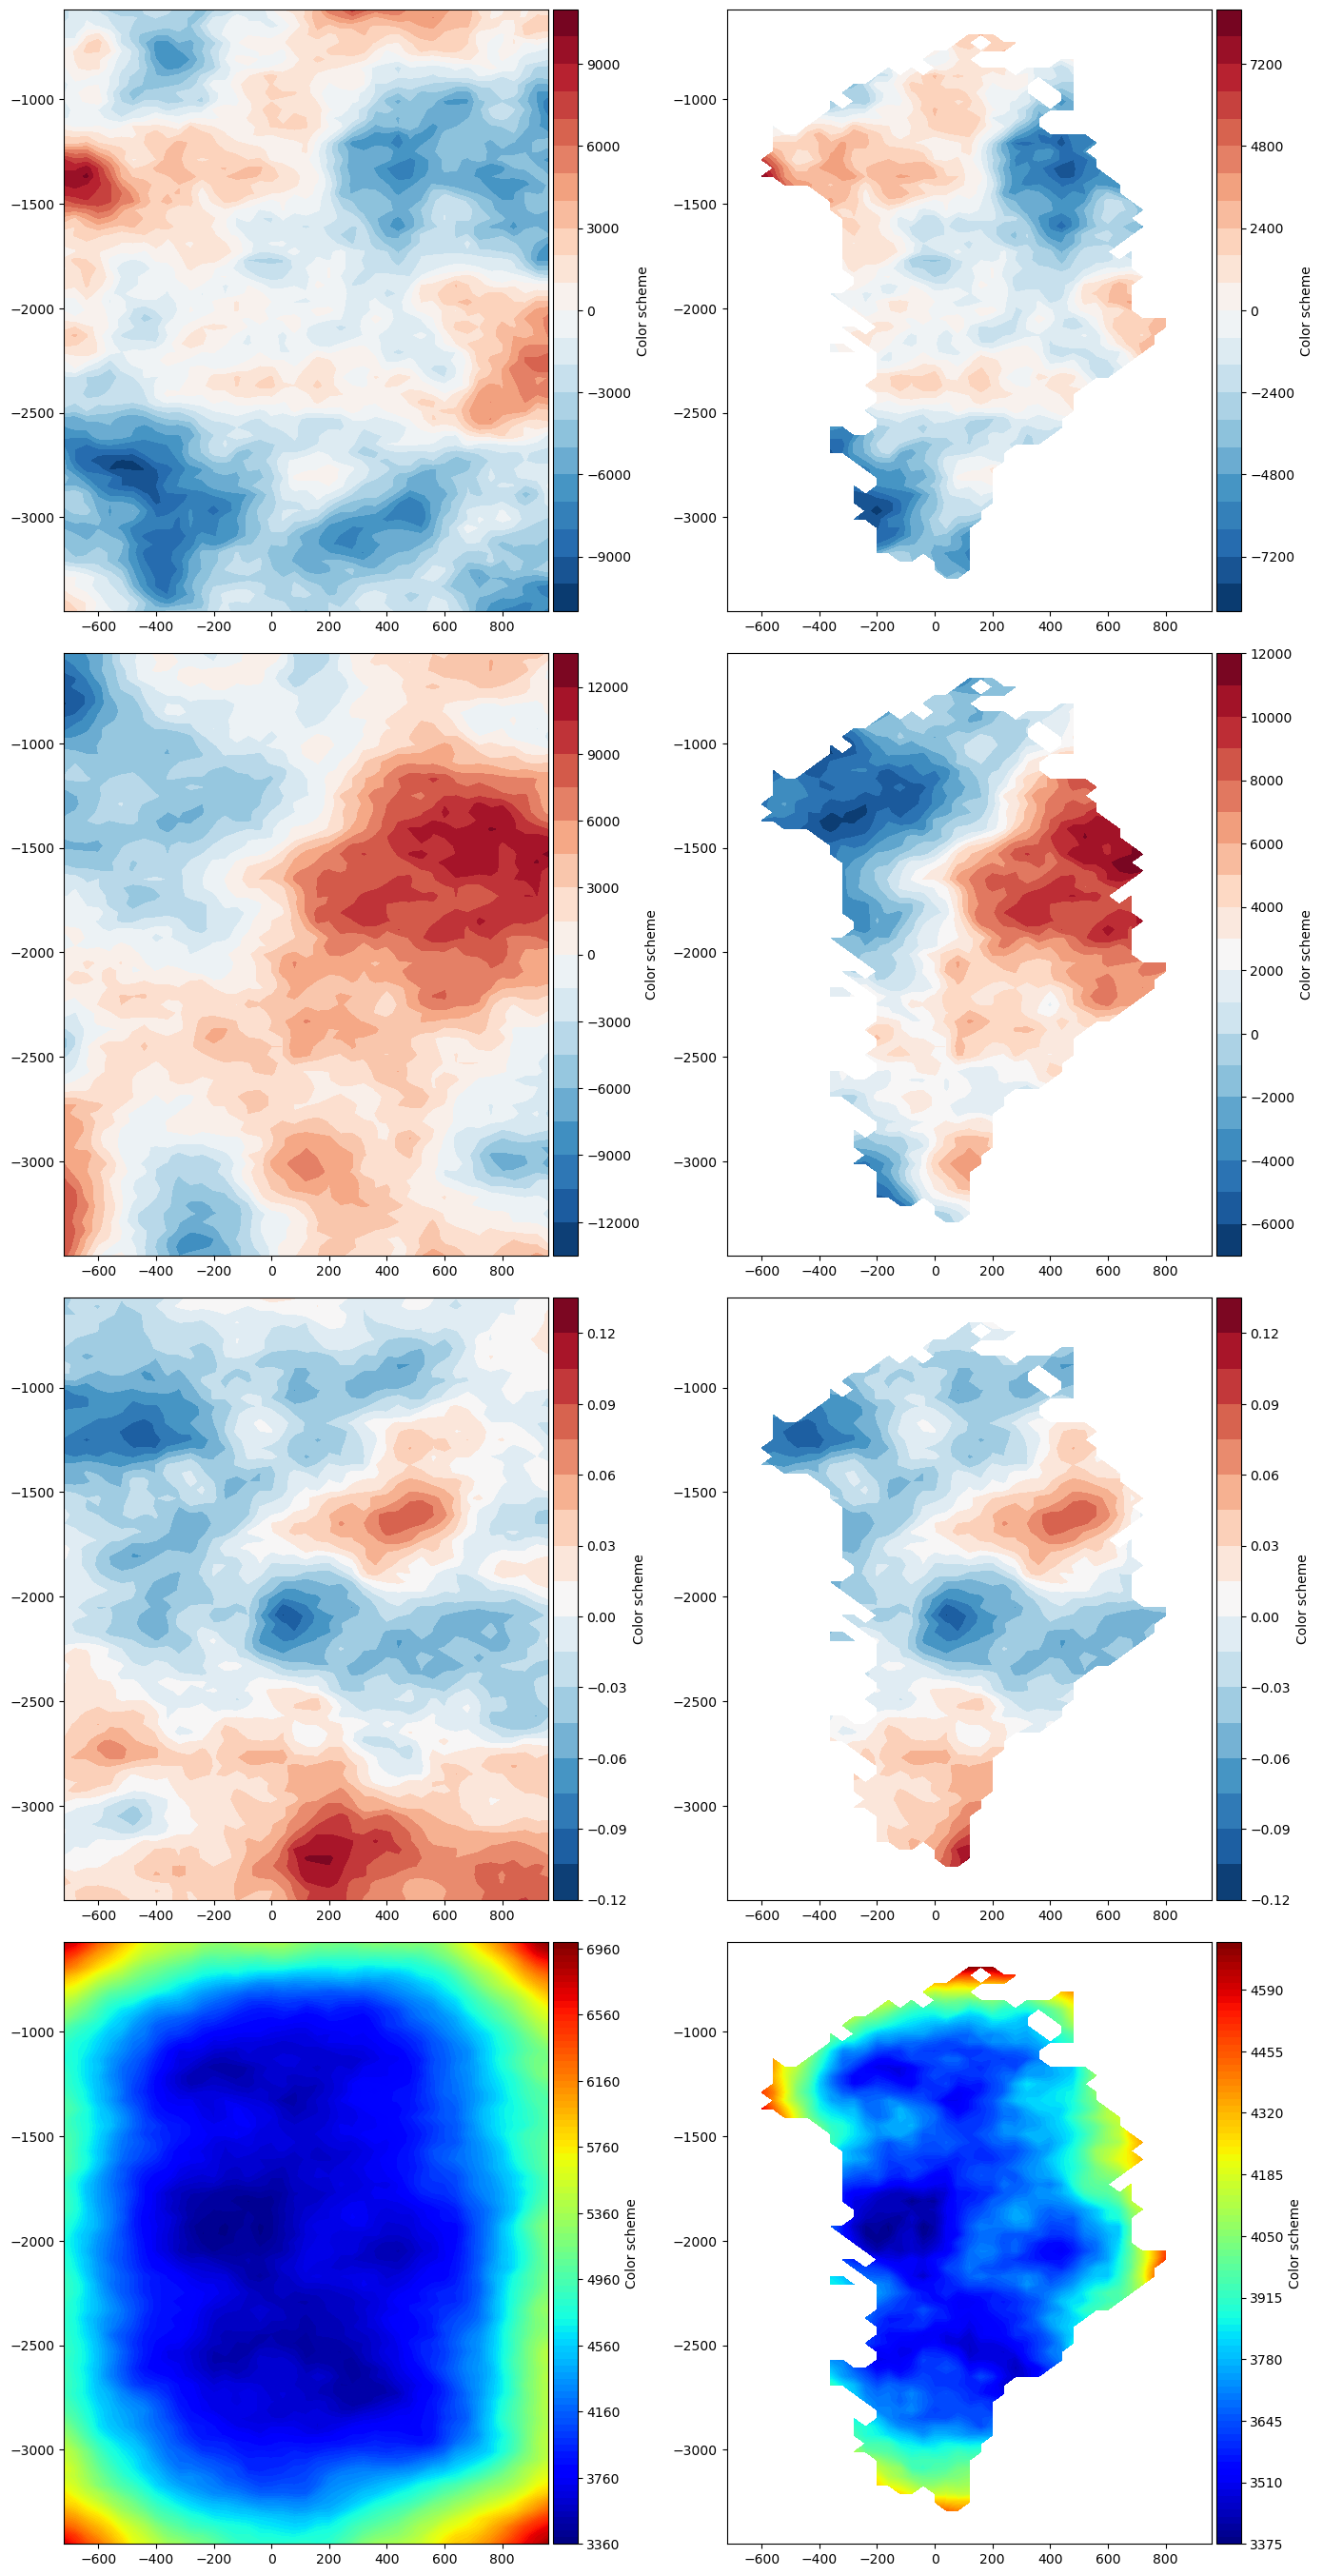

In [4]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", 500, None)

ds_prior_X = DA.ds_prior_X.copy()

ds_subset_sample_prior_C_1 = DA.sample_prior_C()
ds_subset_sample_prior_C_2 = DA.sample_prior_C()
ds_mean_samples_prior_C, ds_std_samples_prior_C = DA.ds_prior_C_mean, DA.ds_prior_C_std

ds_subset_sample_prior_1 = DA.sample_prior()
ds_subset_sample_prior_2 = DA.sample_prior()
ds_mean_samples_prior, ds_std_samples_prior = DA.pointwise_marginals("prior", 500)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_c_slide_initd"].data/ds_std_samples_prior_C["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_c_slide_initd"].data/ds_std_samples_prior_C["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

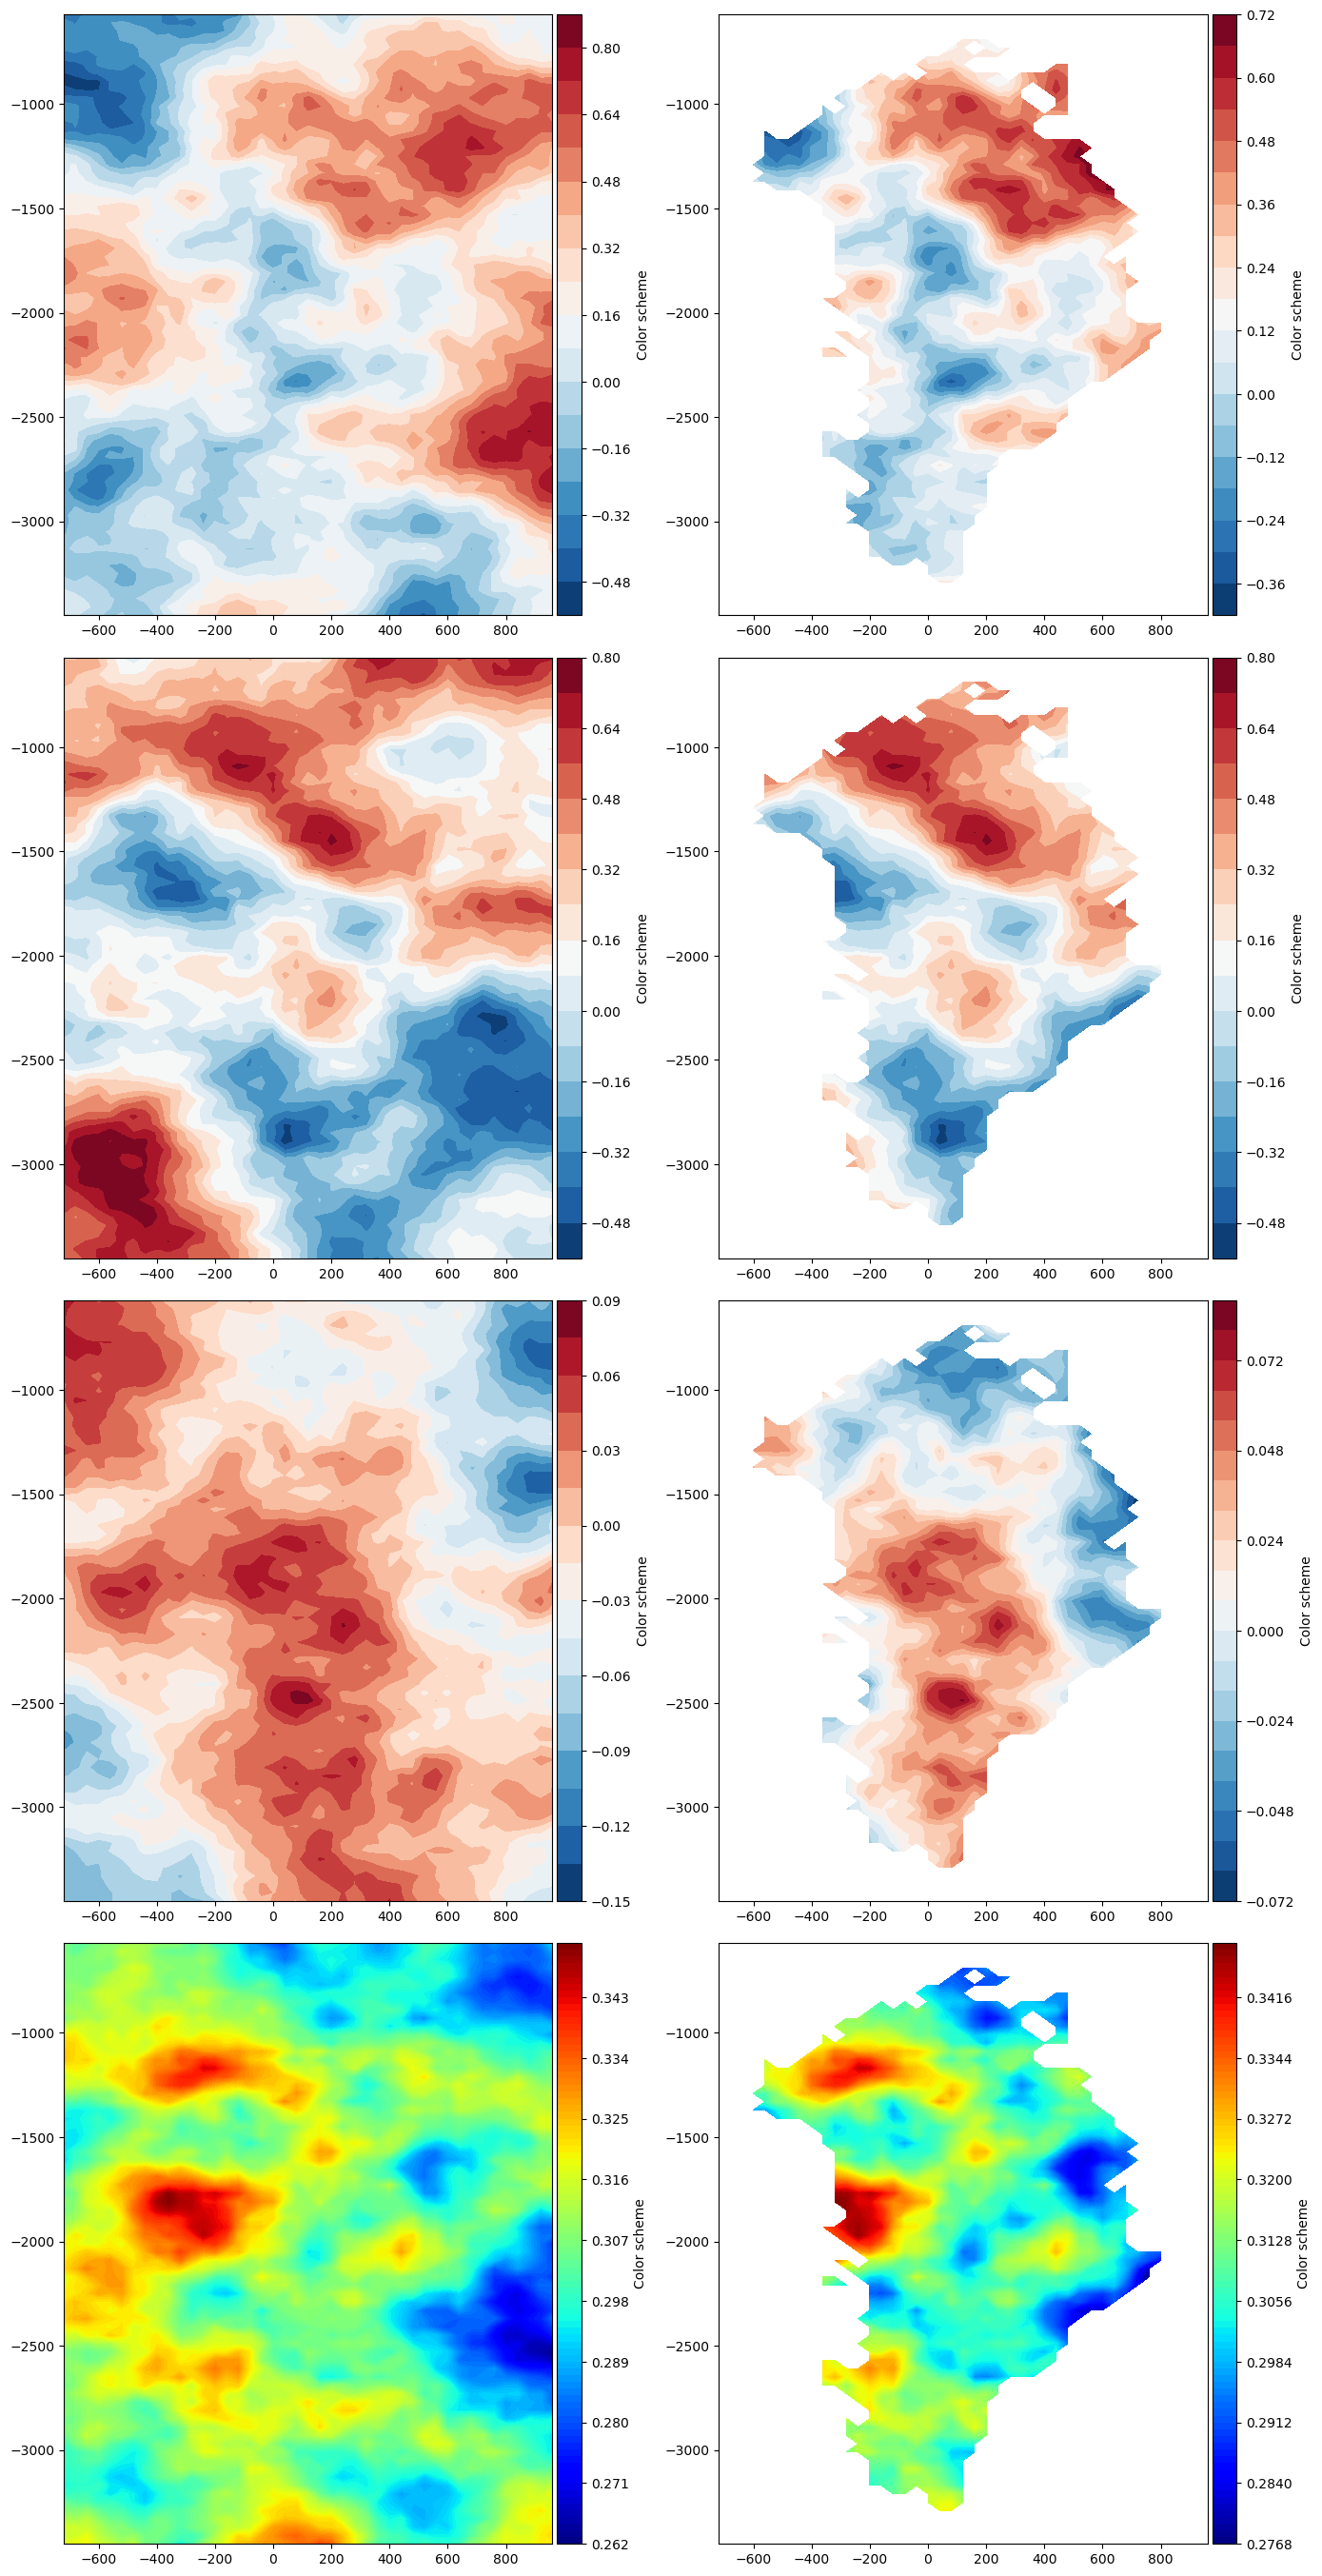

In [5]:
H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [6]:
ds_x = DA.create_ad_tlm_action_input_nc(bool_randomize = True)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(683448.3638196632, 683448.3638196633)

In [7]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(683448.3638196632, 683448.3638196633)

In [8]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_A_SigmaXCx = DA.eval_tlm_action()
ds_noise_cov_inv_A_SigmaXCx = DA.eval_noise_cov_inv_action(ds_A_SigmaXCx)

dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)

ds_CT_XT_SigmaT_H_misfit_SigmaXCx = DA.eval_prior_preconditioned_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), DA.l2_inner_product([ds_A_SigmaXCx, ds_noise_cov_inv_A_SigmaXCx], ["tlmhessaction", "adjhessaction"])

(60830.09197965327, 60830.09197946596)

In [9]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_SigmaXC_inv_SigmaXCx = DA.eval_sqrt_prior_cov_inv_action()

DA.l2_inner_product([ds_SigmaXC_inv_SigmaXCx, ds_SigmaXC_inv_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

(3231.0231917841893, 3231.0231917842075)

In [10]:
DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

(326.719983381524, 3231.0231917842075)

In [11]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()

ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")

ds_SigmaXCx_as_adj_fields = xr.open_dataset(DA.dict_ad_inp_nc_files["tlm_action"])
ds_SigmaXCx_as_adj_fields = ds_SigmaXCx_as_adj_fields.rename({field + "d": field + "b" for field in dict_og_params_fields_vals})
for var in ds_SigmaXCx_as_adj_fields:
    if ds_SigmaXCx_as_adj_fields[var].attrs["type"] == "tlm":
        ds_SigmaXCx_as_adj_fields[var].attrs["type"] = "adj"
        if dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "2D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1))
        elif dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "3D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1)*(KCMAX+1))
ds_SigmaXCx_as_adj_fields.to_netcdf(DA.dict_ad_out_nc_files["adj_action"])

ds_CT_XT_SigmaT_SigmaXCx = DA.eval_sqrt_prior_covT_action(ad_key_adj_or_adj_action = "adj_action")

DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_SigmaXCx], ["tlm", "adj"])

(326.719983381524, 326.71998338180776)

In [12]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_CT_XT_SigmaT_H_SigmaXCx = DA.eval_prior_preconditioned_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]) + DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_SigmaXCx], ["tlm", "adj"])

(60830.09197965327, 64061.11517143748, 64061.11517143747)

---------------------------------------------------------------------------------------------------------------
iter 0, fc = 306335.8028719911, fc_data = 306335.8028719911, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
Too big step size probably crashed the simulation.
Step size alpha = 0.0001220703125
---------------------------------------------------------------------------------------------------------------
iter 1, fc = 296143.34852010093, fc_data = 244967.70578476612, fc_reg = 51175.6427353348
---------------------------------------------------------------------------------------------------------------
Too big step size probably crashed the simulation.
Step size alpha = 0.0009765625
---------------------------------------------------------------------------------------------------------------
iter 2, fc = 294356.9429737514, fc_data = 233037.2716942281, fc_reg = 61319.6712795233
-----------------------

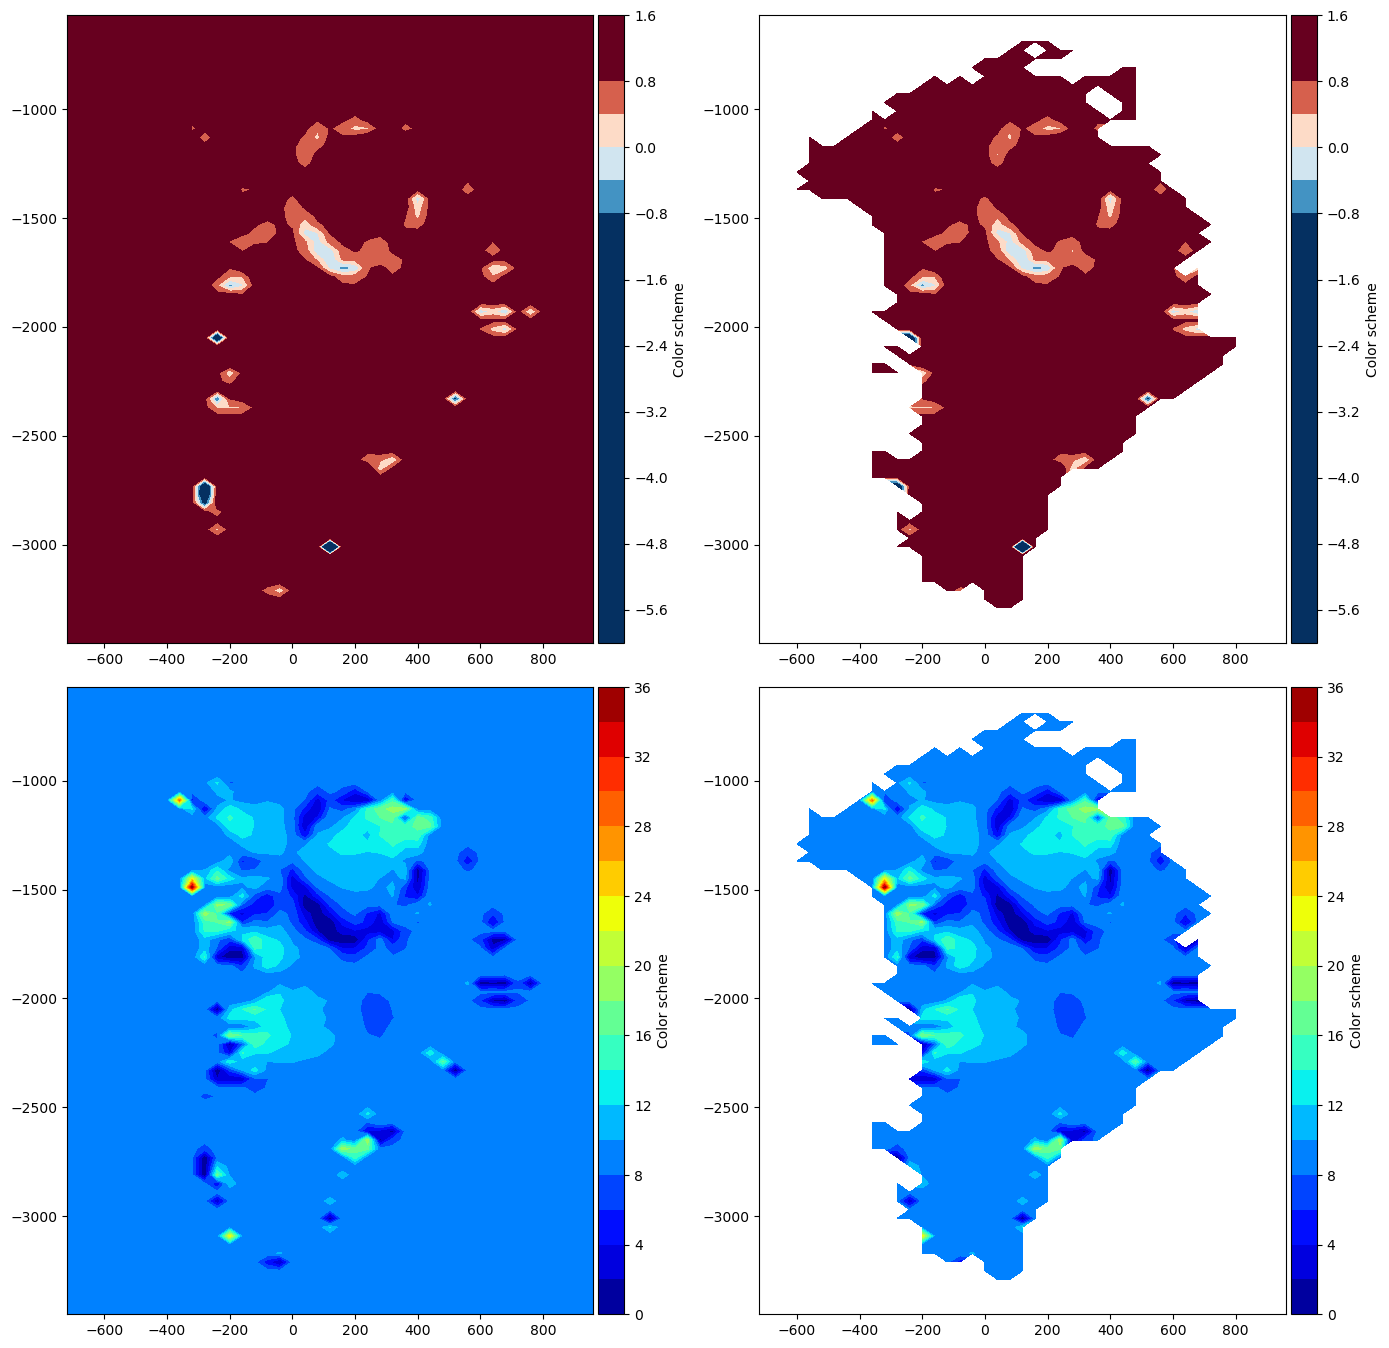

In [13]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", None, ds_prior_X)

ds = DA.gradient_descent(2, init_alpha = 1.0, min_alpha_tol = 1.e-10)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 2, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -1, vmax = 1, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -1, vmax = 1, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data*mask,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
plt.tight_layout()

---------------------------------------------------------------------------------------------------------------
Initial fc = 306335.8028719911, fc_data = 306335.8028719911, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 25250.491985953613, norm_r_hat: 9534.242820035774
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  179.99999914622634
Step size alpha = 1.0
---------------------------------------------------------------------------------------------------------------
Outer iter 1, fc = 259102.0226429456, fc_data = 259099.96326046868, fc_reg = 2.0593824769386964
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 4148.846837630217, norm_r_hat: 3795.409408791992
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  180.0
Step size alpha = 1.0
------------------

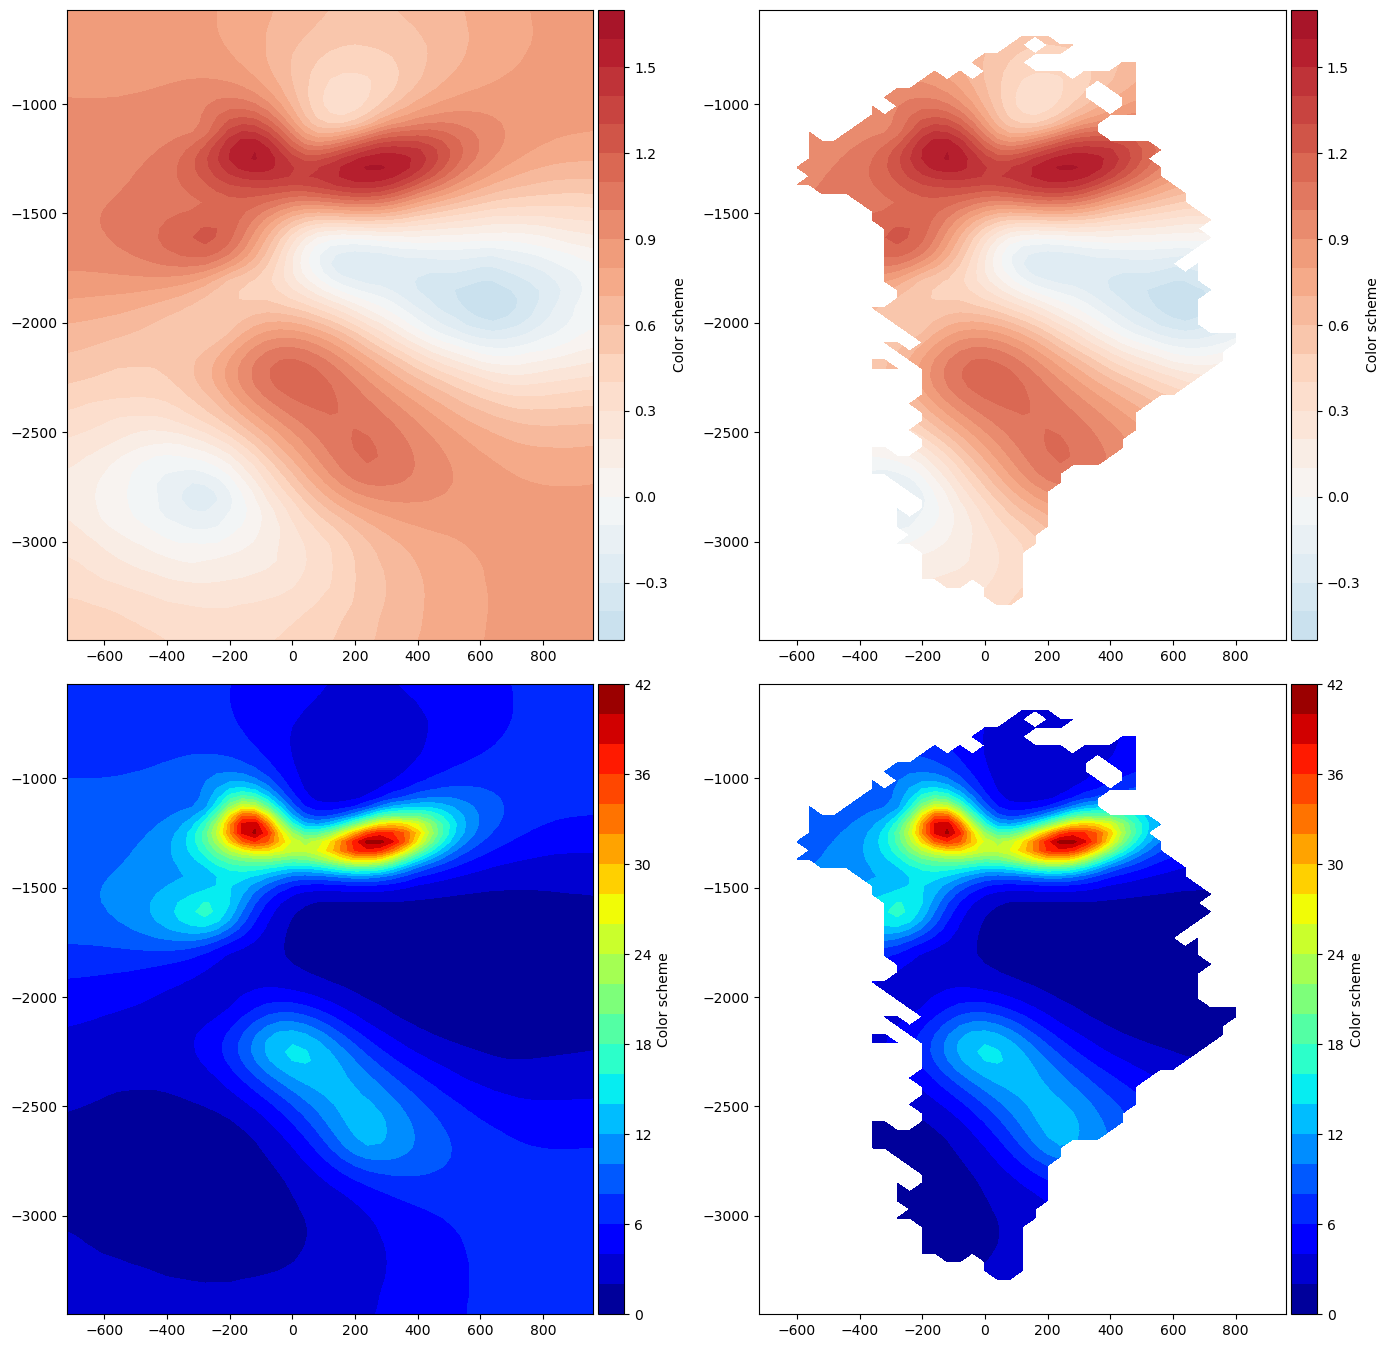

In [14]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", None, ds_prior_X)

ds = DA.inexact_gn_hessian_cg(MAX_ITERS=5, min_alpha_cg_tol = 1.e-20, init_alpha_gd = 1.e-6, min_alpha_gd_tol = 1.e-20)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 2, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data*mask,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
plt.tight_layout()

Double precise total time: 1543.2876 seconds
Single approx total time: 774.6092 seconds


(array([1.71056375e+04, 1.40734202e+04, 6.11151781e+03, 3.12767826e+03,
        1.84318697e+03, 1.00197127e+03, 6.68492061e+02, 5.43708772e+02,
        5.01392268e+02, 4.26737457e+02, 3.37739193e+02, 2.76161146e+02,
        1.81267458e+02, 1.57471089e+02, 1.50757561e+02, 1.30948421e+02,
        1.10444450e+02, 8.90054948e+01, 8.21639613e+01, 6.71896857e+01,
        5.43944474e+01, 4.81564330e+01, 4.33701156e+01, 3.57659185e+01,
        3.41675149e+01, 3.03302341e+01, 2.98516626e+01, 2.39213191e+01,
        2.10344312e+01, 1.98197865e+01, 1.73534670e+01, 1.68955486e+01,
        1.56911288e+01, 1.38010642e+01, 1.24159638e+01, 1.05416687e+01,
        8.94246578e+00, 7.77462720e+00, 6.28515321e+00, 5.48312611e+00]),
 array([1.70736558e+04, 1.40322713e+04, 6.09031791e+03, 3.10823769e+03,
        1.80381796e+03, 9.87179449e+02, 6.45648203e+02, 5.18985416e+02,
        4.65154581e+02, 4.05296183e+02, 3.24038489e+02, 2.59130141e+02,
        1.64202898e+02, 1.38777901e+02, 1.28345345e+02, 1.1229

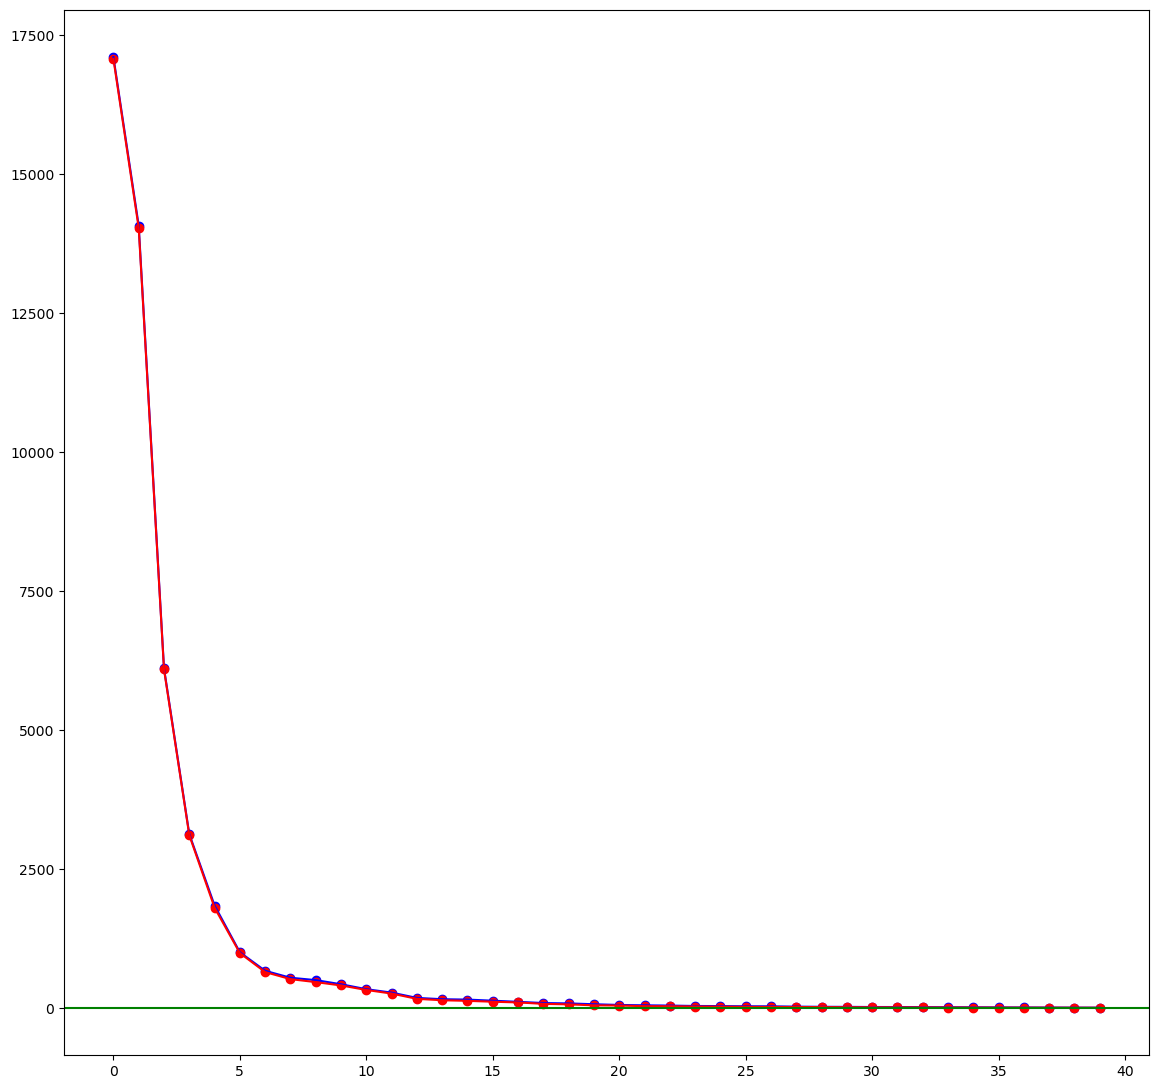

In [15]:
start_dp = time.time()

Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
                                                                                                              Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
                                                                                                              Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Double precise total time: 1545.7253 seconds
Single approx total time: 768.9954 seconds


(array([1.71056512e+04, 1.40734380e+04, 6.11143249e+03, 3.12774617e+03,
        1.84328995e+03, 1.00208861e+03, 6.68659631e+02, 5.43545297e+02,
        5.01529919e+02, 4.26534893e+02, 3.36873500e+02, 2.74304455e+02,
        1.81066617e+02, 1.56262352e+02, 1.51318196e+02, 1.31391203e+02,
        1.10240213e+02, 8.95294076e+01, 8.20812002e+01, 6.91608902e+01,
        5.54805295e+01, 4.83528952e+01, 4.28502488e+01, 3.57633318e+01,
        3.31765280e+01, 3.07067973e+01, 2.83408858e+01, 2.34263012e+01,
        2.18111235e+01, 1.93350231e+01, 1.88550337e+01, 1.75934278e+01,
        1.64451162e+01, 1.28591354e+01, 1.15629490e+01, 1.01345443e+01,
        8.49558312e+00, 7.49522730e+00, 7.38155616e+00, 5.85338774e+00]),
 array([1.70746917e+04, 1.40425069e+04, 6.08908303e+03, 3.10433918e+03,
        1.82991845e+03, 9.83966240e+02, 6.36186971e+02, 5.30322417e+02,
        4.78696073e+02, 3.97405205e+02, 3.27100344e+02, 2.46821490e+02,
        1.56762862e+02, 1.36496035e+02, 1.35146871e+02, 1.1656

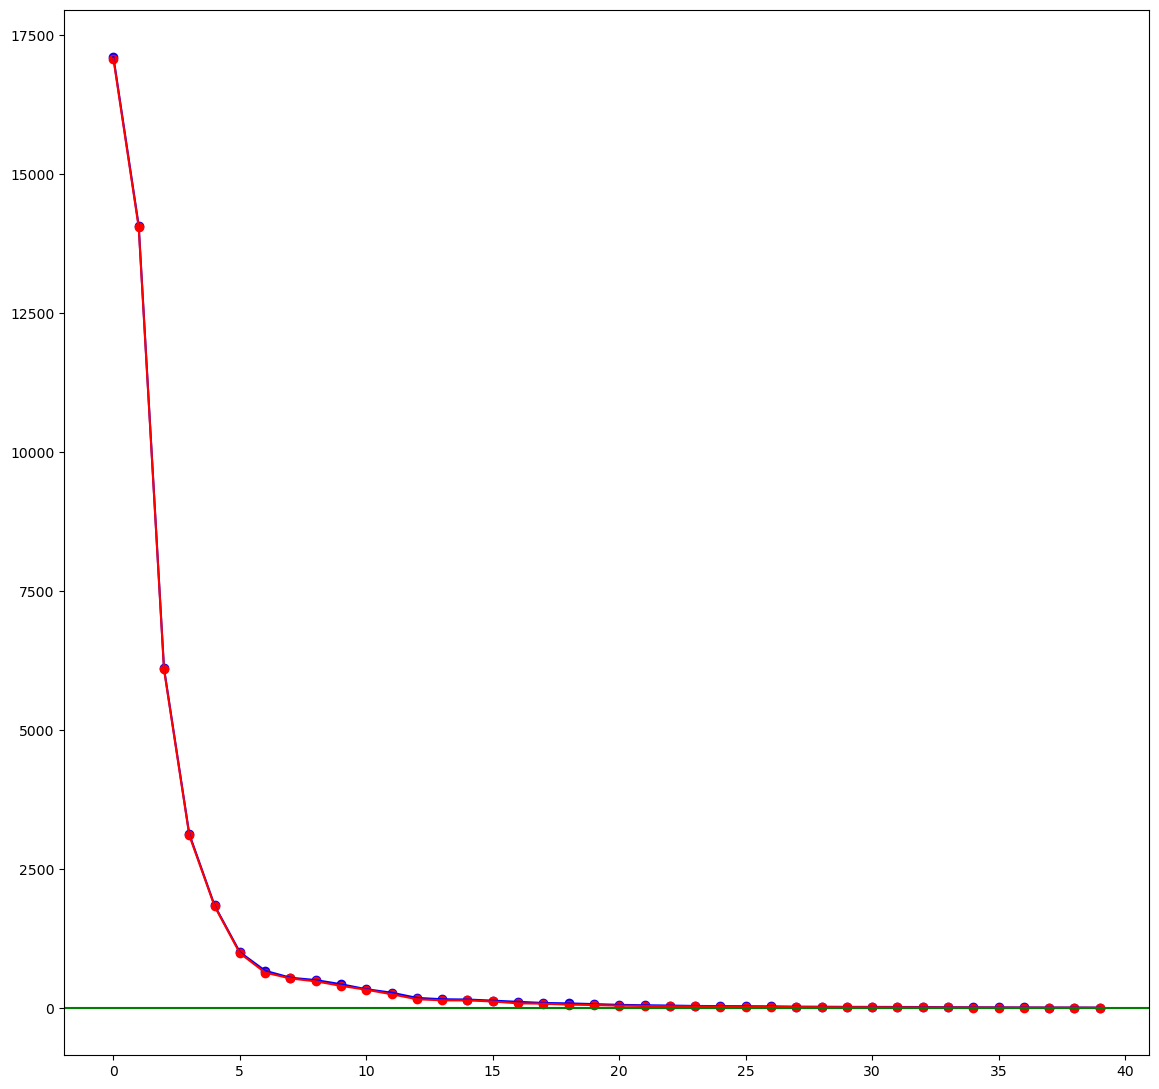

In [16]:
start_dp = time.time()

Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
Omega_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/Omega_misfit.npy")
Y_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/Y_misfit.npy")
Q_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/Q_misfit.npy")
MQ_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/MQ_misfit.npy")
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
                                                                                                              Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
Omega_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/Omega_misfit.npy")
Y_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/Y_misfit.npy")
Q_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/Q_misfit.npy")
MQ_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/MQ_misfit.npy")
Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
                                                                                                              Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Double precise total time: 1543.5171 seconds
Single approx total time: 769.4437 seconds


(array([1.71056541e+04, 1.40734226e+04, 6.11151422e+03, 3.12775879e+03,
        1.84327020e+03, 1.00209330e+03, 6.68528005e+02, 5.43506942e+02,
        5.01308866e+02, 4.26612398e+02, 3.37286392e+02, 2.75764790e+02,
        1.81154499e+02, 1.56811689e+02, 1.51404124e+02, 1.31119132e+02,
        1.10079639e+02, 8.94159227e+01, 8.19627847e+01, 6.89911928e+01,
        5.45552039e+01, 4.74460534e+01, 4.34001710e+01, 3.47023874e+01,
        3.40872837e+01, 3.04217258e+01, 2.64551329e+01, 2.31574024e+01,
        2.01795925e+01, 1.91106932e+01, 1.85683266e+01, 1.54853636e+01,
        1.42853482e+01, 1.22063986e+01, 1.15088726e+01, 1.05281801e+01,
        9.90068627e+00, 8.37844411e+00, 7.39687934e+00, 6.23083123e+00]),
 array([1.70801242e+04, 1.40360276e+04, 6.09368939e+03, 3.09994432e+03,
        1.82081703e+03, 9.77636324e+02, 6.49120268e+02, 4.97742613e+02,
        4.77439261e+02, 4.09011843e+02, 3.14656605e+02, 2.62952696e+02,
        1.50931727e+02, 1.27918762e+02, 1.14339756e+02, 9.8852

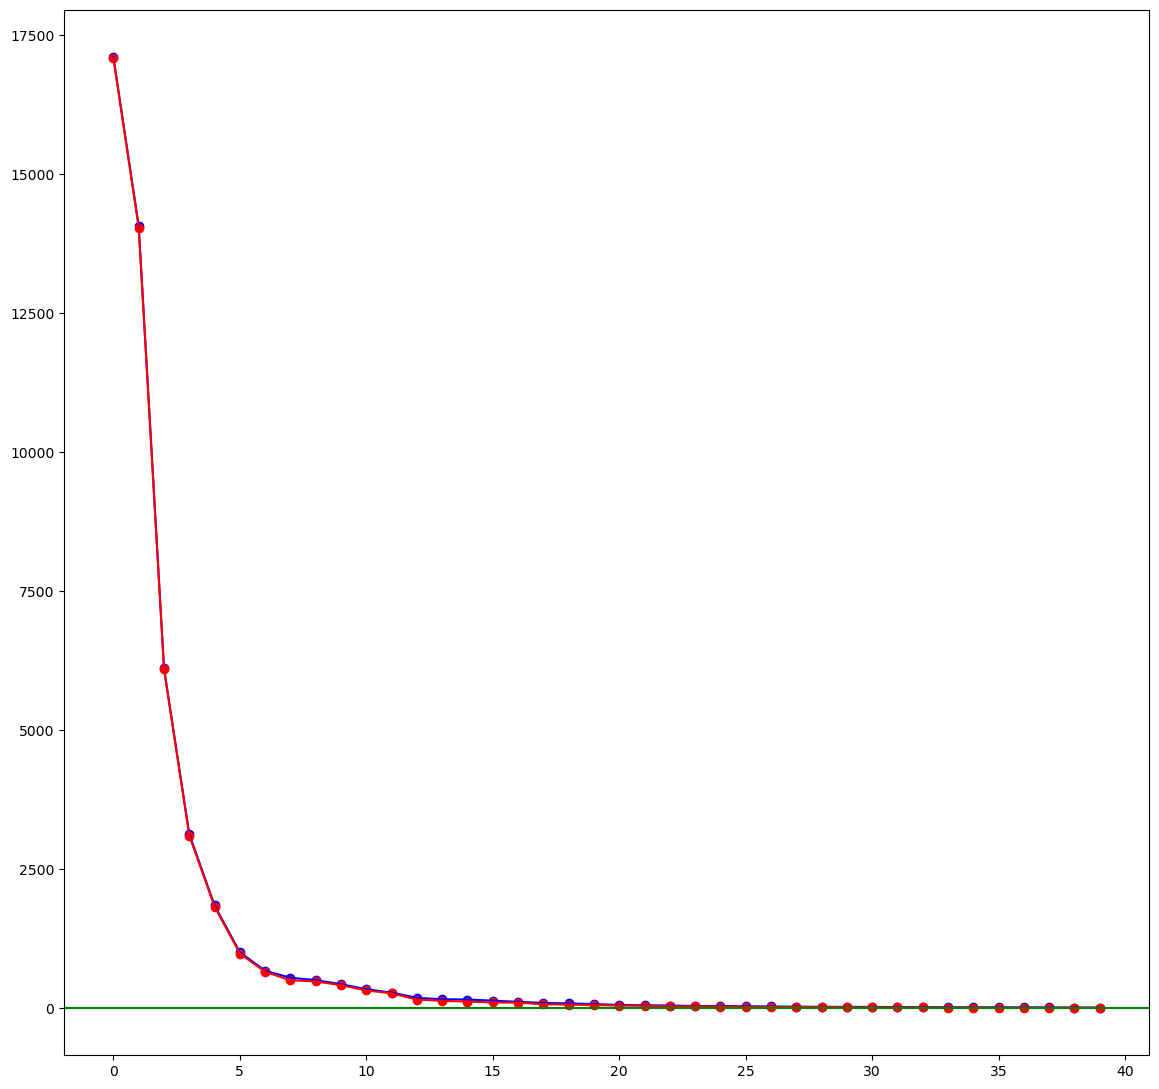

In [17]:
start_dp = time.time()
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(30, 10, mode = "misfit_prior_precond", str_pass = "double_precise")

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(30, 10, mode = "misfit_prior_precond", str_pass = "single_approx")

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Double precise total time: 1548.1584 seconds
Single approx total time: 774.9958 seconds


(array([1.83648529e+03, 6.77500234e+02, 5.62344333e+02, 3.47556653e+02,
        2.22095905e+02, 1.94082601e+02, 1.10954482e+02, 1.04201249e+02,
        7.82195260e+01, 6.69490593e+01, 6.08506174e+01, 3.87461005e+01,
        2.82182477e+01, 2.62926308e+01, 2.38608242e+01, 2.16057251e+01,
        1.63632844e+01, 1.43987191e+01, 1.22648733e+01, 1.07436170e+01,
        8.58257323e+00, 7.65469205e+00, 5.74946740e+00, 4.99685461e+00,
        4.55793218e+00, 4.41758398e+00, 3.66828058e+00, 3.47093348e+00,
        3.17895911e+00, 2.42204699e+00, 2.36970679e+00, 2.13943304e+00,
        1.86207174e+00, 1.84355572e+00, 1.62793213e+00, 1.51621135e+00,
        1.45355982e+00, 1.29225568e+00, 1.10716323e+00, 9.76610113e-01]),
 array([1.83406899e+03, 6.74570133e+02, 5.58812997e+02, 3.42926362e+02,
        2.17349687e+02, 1.89070462e+02, 1.07813266e+02, 9.89839213e+01,
        7.54618365e+01, 6.26677415e+01, 5.66089166e+01, 3.55888342e+01,
        2.55471867e+01, 2.41405803e+01, 2.15557500e+01, 1.8225

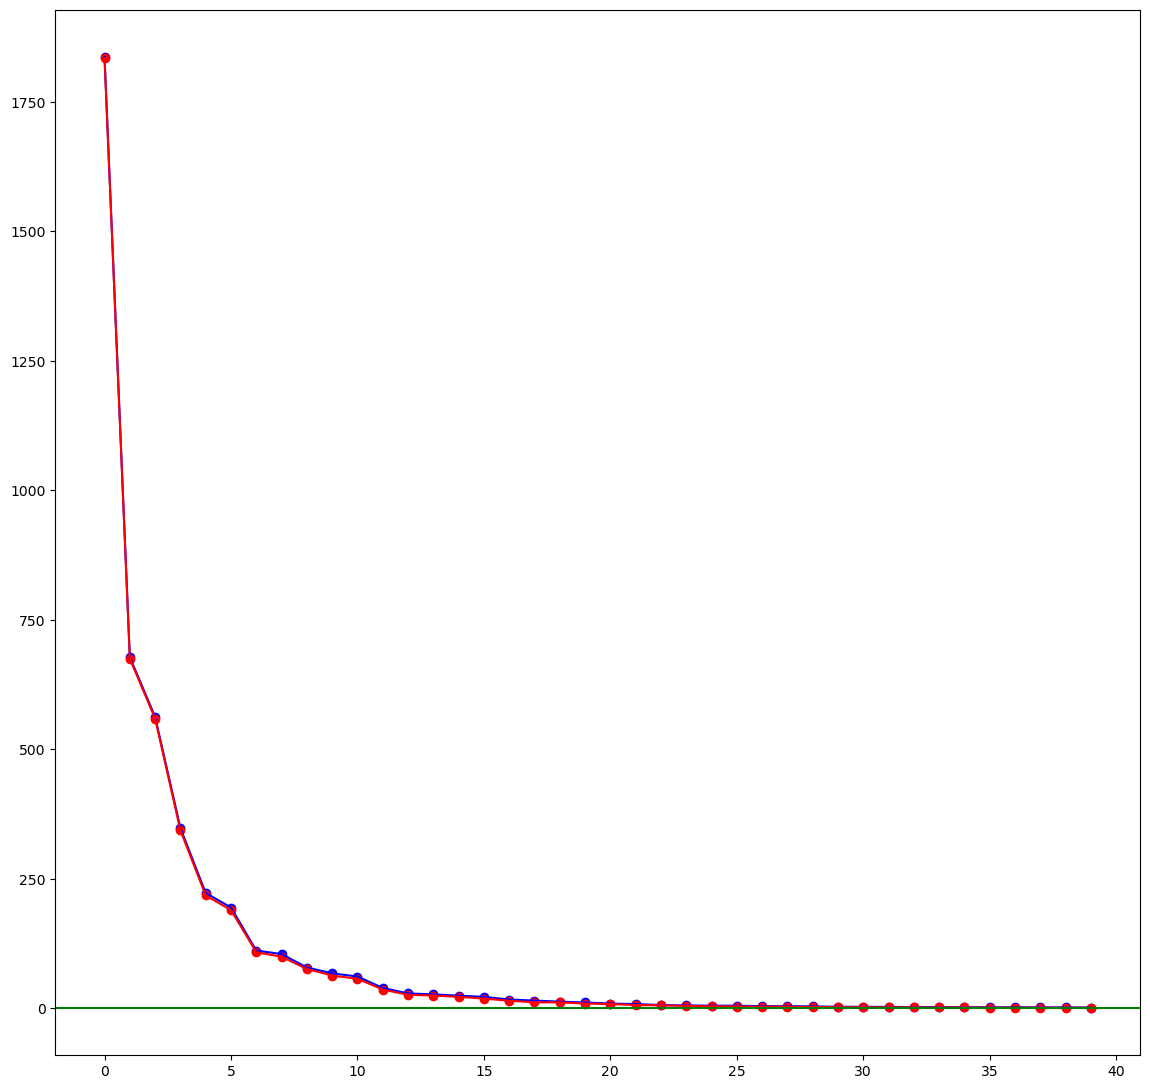

In [18]:
ds_state = xr.open_dataset("/scratch2/shreyas/tuneCS_mini/inexact_gn_hessian_cg/state_GNHessCG_iter_2.nc")
ds_prior_X = xr.open_dataset("/scratch2/shreyas/tuneCS_mini/prior_X.nc")

dict_og_params_fields_vals = {"xx_c_slide_init": ds_state["xx_c_slide_init"].data.copy(),
                              "xx_p_weert": ds_state["xx_p_weert"].data[0].copy(),
                              "xx_q_weert": ds_state["xx_q_weert"].data[0].copy(),
                              "xx_enh_fact_da_dummy2d_scalar": ds_state["xx_enh_fact_da_dummy2d_scalar"].data[0].copy(),
                              "xx_enh_intg_da_dummy2d_scalar": ds_state["xx_enh_intg_da_dummy2d_scalar"].data[0].copy()}

DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", None, ds_prior_X)

start_dp = time.time()

Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise")
Omega_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/Omega_misfit.npy")
Y_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/Y_misfit.npy")
Q_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/Q_misfit.npy")
MQ_misfit_dp = np.load("/scratch2/shreyas/tuneCS_mini/REVD_double_precise/MQ_misfit.npy")
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "double_precise", 
                                                                                                              Omega = Omega_misfit_dp, Y = Y_misfit_dp, Q = Q_misfit_dp, MQ = MQ_misfit_dp)

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "single_approx")
Omega_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/Omega_misfit.npy")
Y_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/Y_misfit.npy")
Q_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/Q_misfit.npy")
MQ_misfit_sa = np.load("/scratch2/shreyas/tuneCS_mini/REVD_single_approx/MQ_misfit.npy")
Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(15, 5, mode = "misfit_prior_precond", str_pass = "single_approx", 
                                                                                                              Omega = Omega_misfit_sa, Y = Y_misfit_sa, Q = Q_misfit_sa, MQ = MQ_misfit_sa)

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

Double precise total time: 9678.6387 seconds
Single approx total time: 4863.9486 seconds


(array([1.83648754e+03, 6.77507109e+02, 5.62359396e+02, 3.47565425e+02,
        2.22104615e+02, 1.94100505e+02, 1.10998961e+02, 1.04220565e+02,
        7.83277601e+01, 6.70709939e+01, 6.08882344e+01, 3.88524655e+01,
        2.82833909e+01, 2.65044707e+01, 2.40864560e+01, 2.18904290e+01,
        1.66058352e+01, 1.45259582e+01, 1.24265877e+01, 1.09669426e+01,
        8.87084946e+00, 8.11066725e+00, 6.19051923e+00, 5.79114855e+00,
        5.48267272e+00, 4.82090468e+00, 4.23224870e+00, 4.18518191e+00,
        3.64189715e+00, 3.42755961e+00, 2.87604714e+00, 2.52261303e+00,
        2.47913520e+00, 2.35607029e+00, 2.34714281e+00, 2.30263863e+00,
        2.05938165e+00, 1.95223081e+00, 1.86066154e+00, 1.76913651e+00,
        1.64804786e+00, 1.59397171e+00, 1.44515797e+00, 1.31686239e+00,
        1.26013492e+00, 1.17384357e+00, 1.13978351e+00, 1.12161922e+00,
        1.05695849e+00, 9.60108148e-01, 9.34371667e-01, 8.96801106e-01,
        8.83606720e-01, 8.24616129e-01, 7.90140210e-01, 7.843328

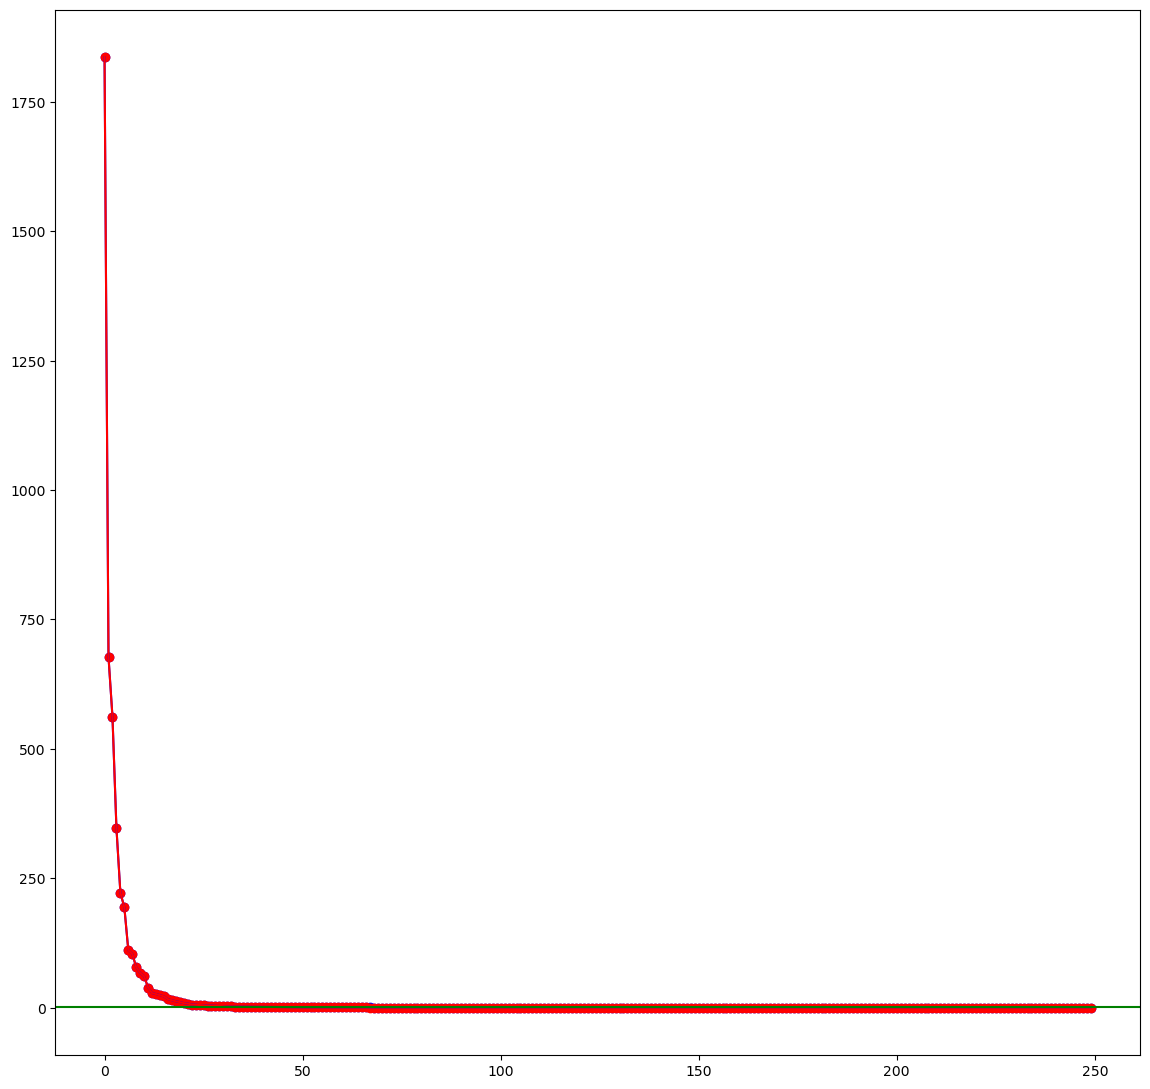

In [19]:
start_dp = time.time()
Omega_misfit_dp, Y_misfit_dp, Q_misfit_dp, MQ_misfit_dp, U_misfit_dp, Lambda_misfit_dp, S_misfit_dp = DA.revd(200, 50, mode = "misfit_prior_precond", str_pass = "double_precise")

end_dp = time.time()
print(f"Double precise total time: {end_dp - start_dp:.4f} seconds")
start_sa = time.time()

Omega_misfit_sa, Y_misfit_sa, Q_misfit_sa, MQ_misfit_sa, U_misfit_sa, Lambda_misfit_sa, S_misfit_sa = DA.revd(200, 50, mode = "misfit_prior_precond", str_pass = "single_approx")

end_sa = time.time()
print(f"Single approx total time: {end_sa - start_sa:.4f} seconds")

plt.scatter(np.arange(Lambda_misfit_dp.shape[0]), np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.plot(np.sort(Lambda_misfit_dp)[::-1], color = "blue")
plt.scatter(np.arange(Lambda_misfit_sa.shape[0]), np.sort(Lambda_misfit_sa)[::-1], color = "red")
plt.plot(np.sort(Lambda_misfit_sa)[::-1], color = "red")

plt.axhline(1, color = "green")

np.sort(Lambda_misfit_dp)[::-1], np.sort(Lambda_misfit_sa)[::-1]

In [20]:
sigma_B_squared_dp, sigma_P_squared_dp, delta_sigma_qoi_squared_dp = DA.forward_uq_propagation(U_misfit_dp, Lambda_misfit_dp)
sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa = DA.forward_uq_propagation(U_misfit_sa, Lambda_misfit_sa)

sigma_B_squared_dp, sigma_P_squared_dp, delta_sigma_qoi_squared_dp, sigma_B_squared_sa, sigma_P_squared_sa, delta_sigma_qoi_squared_sa

(1.2532123307892447e+19,
 3.070658538642749e+17,
 0.9754976992868486,
 1.2532123307892447e+19,
 3.08554673265347e+17,
 0.9753788990353274)

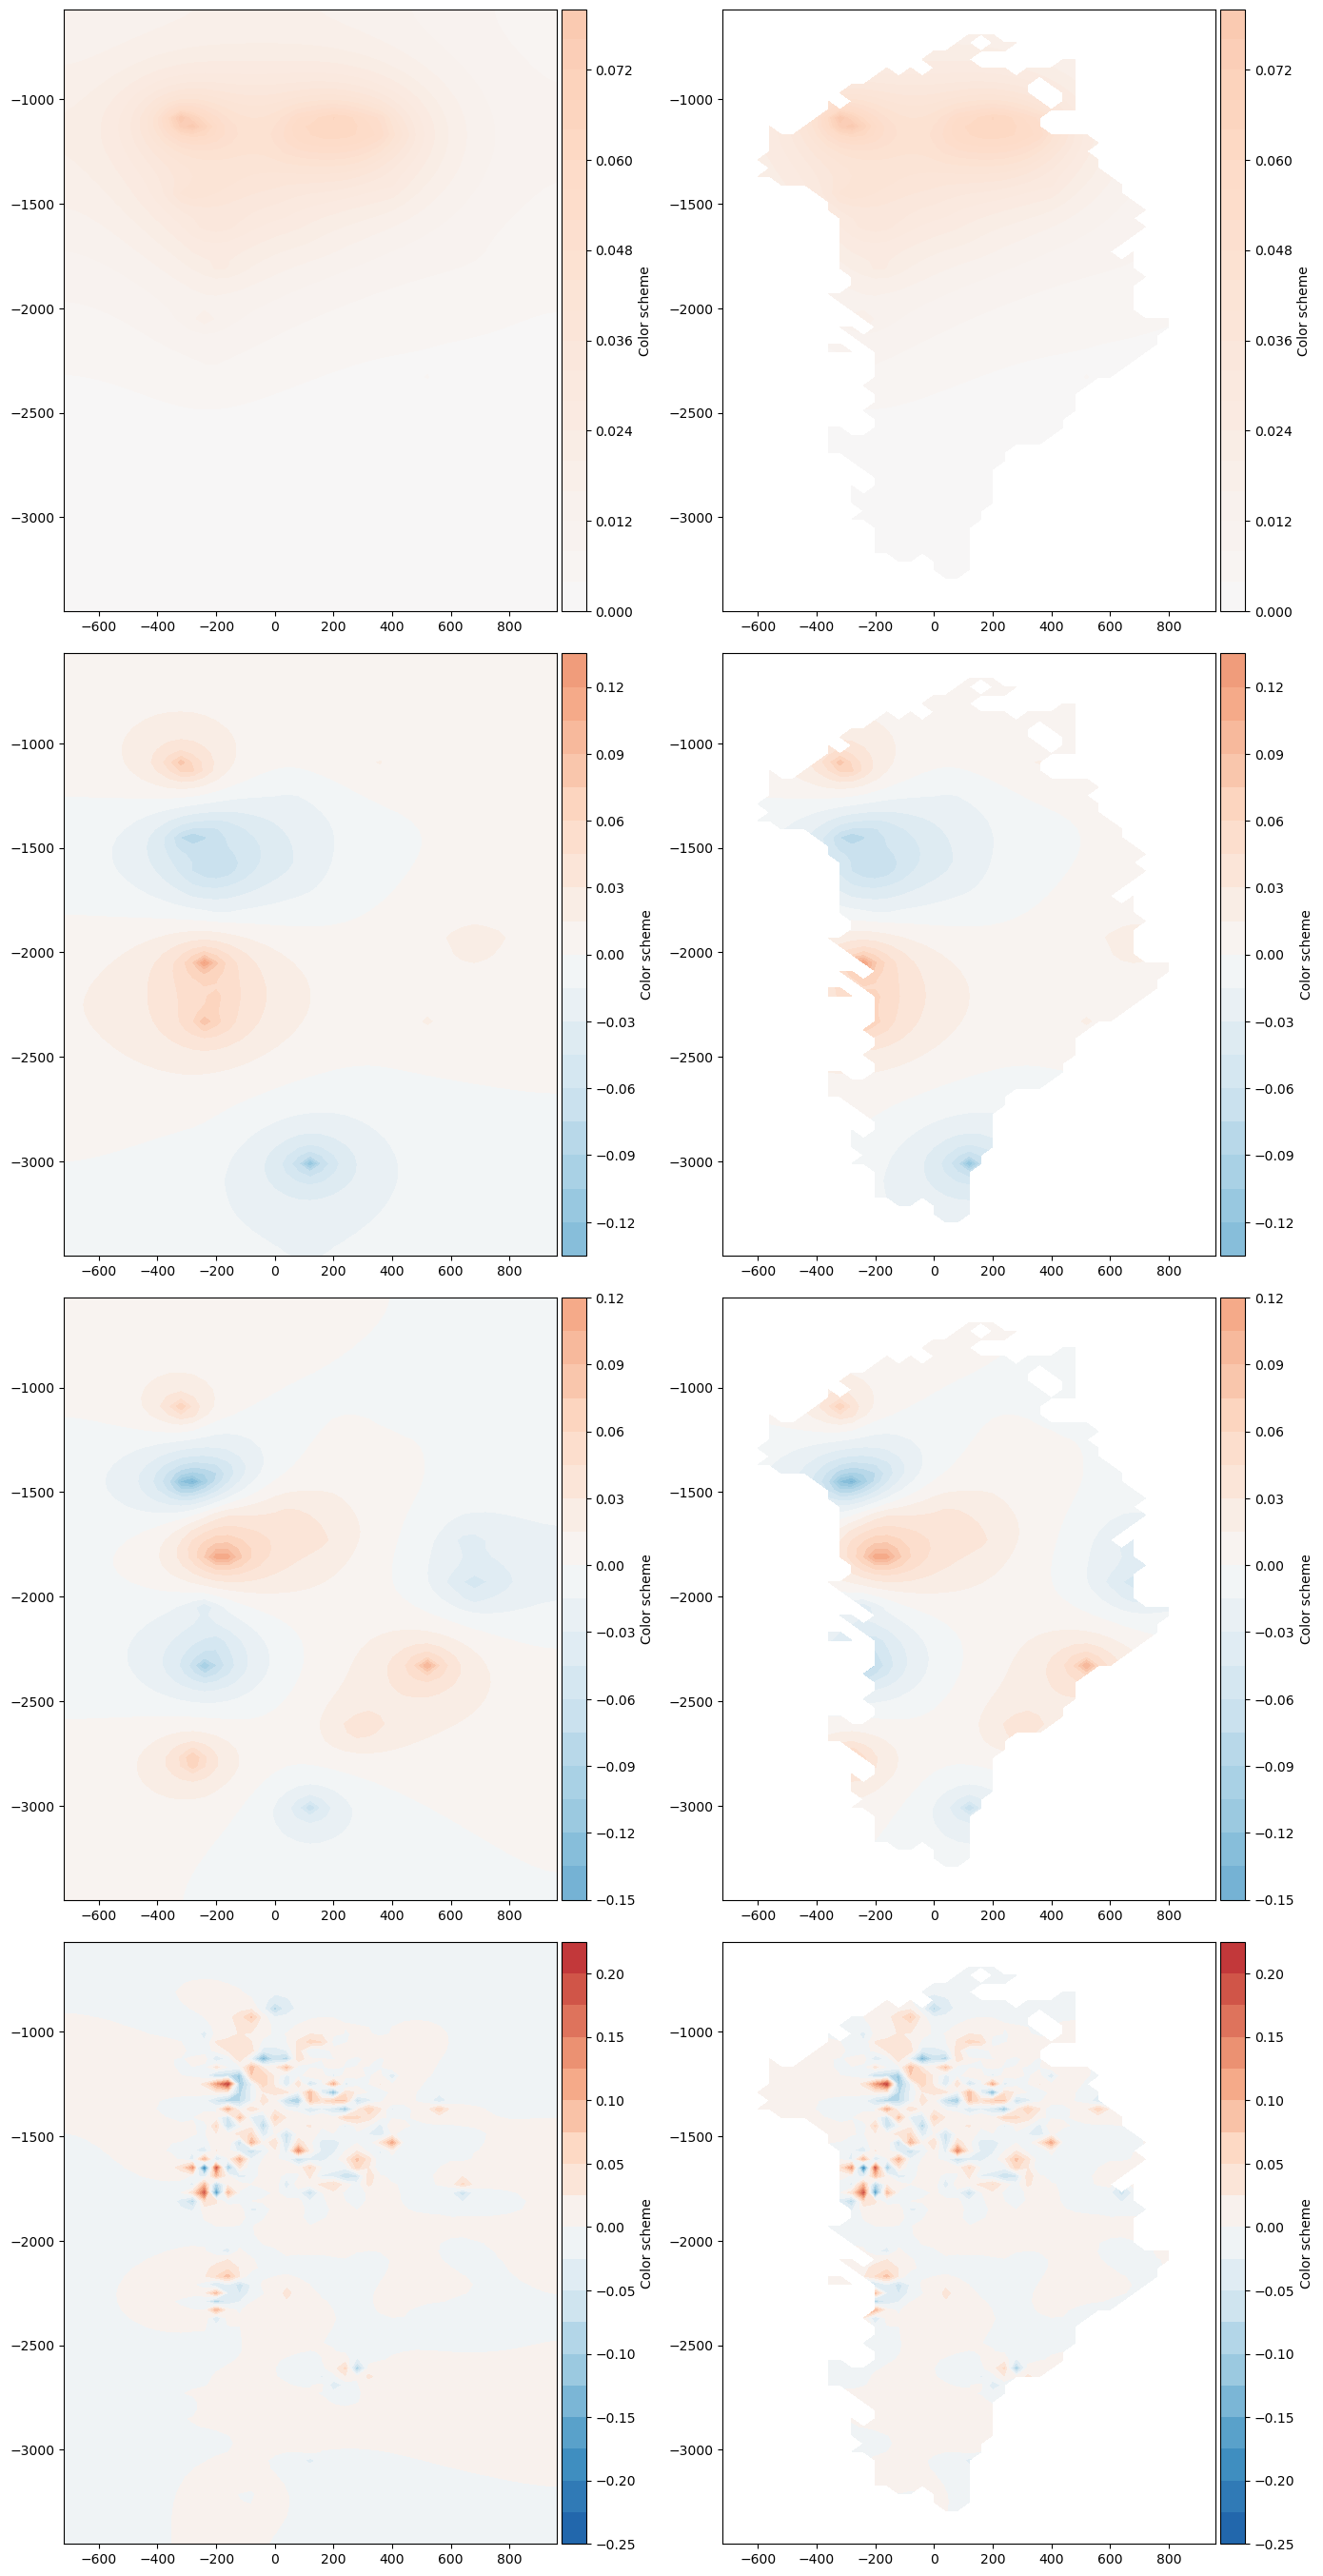

In [21]:
U_misfit_dp_reshaped = np.reshape(U_misfit_dp, (73, 43, -1))

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_dp_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
plt.tight_layout()

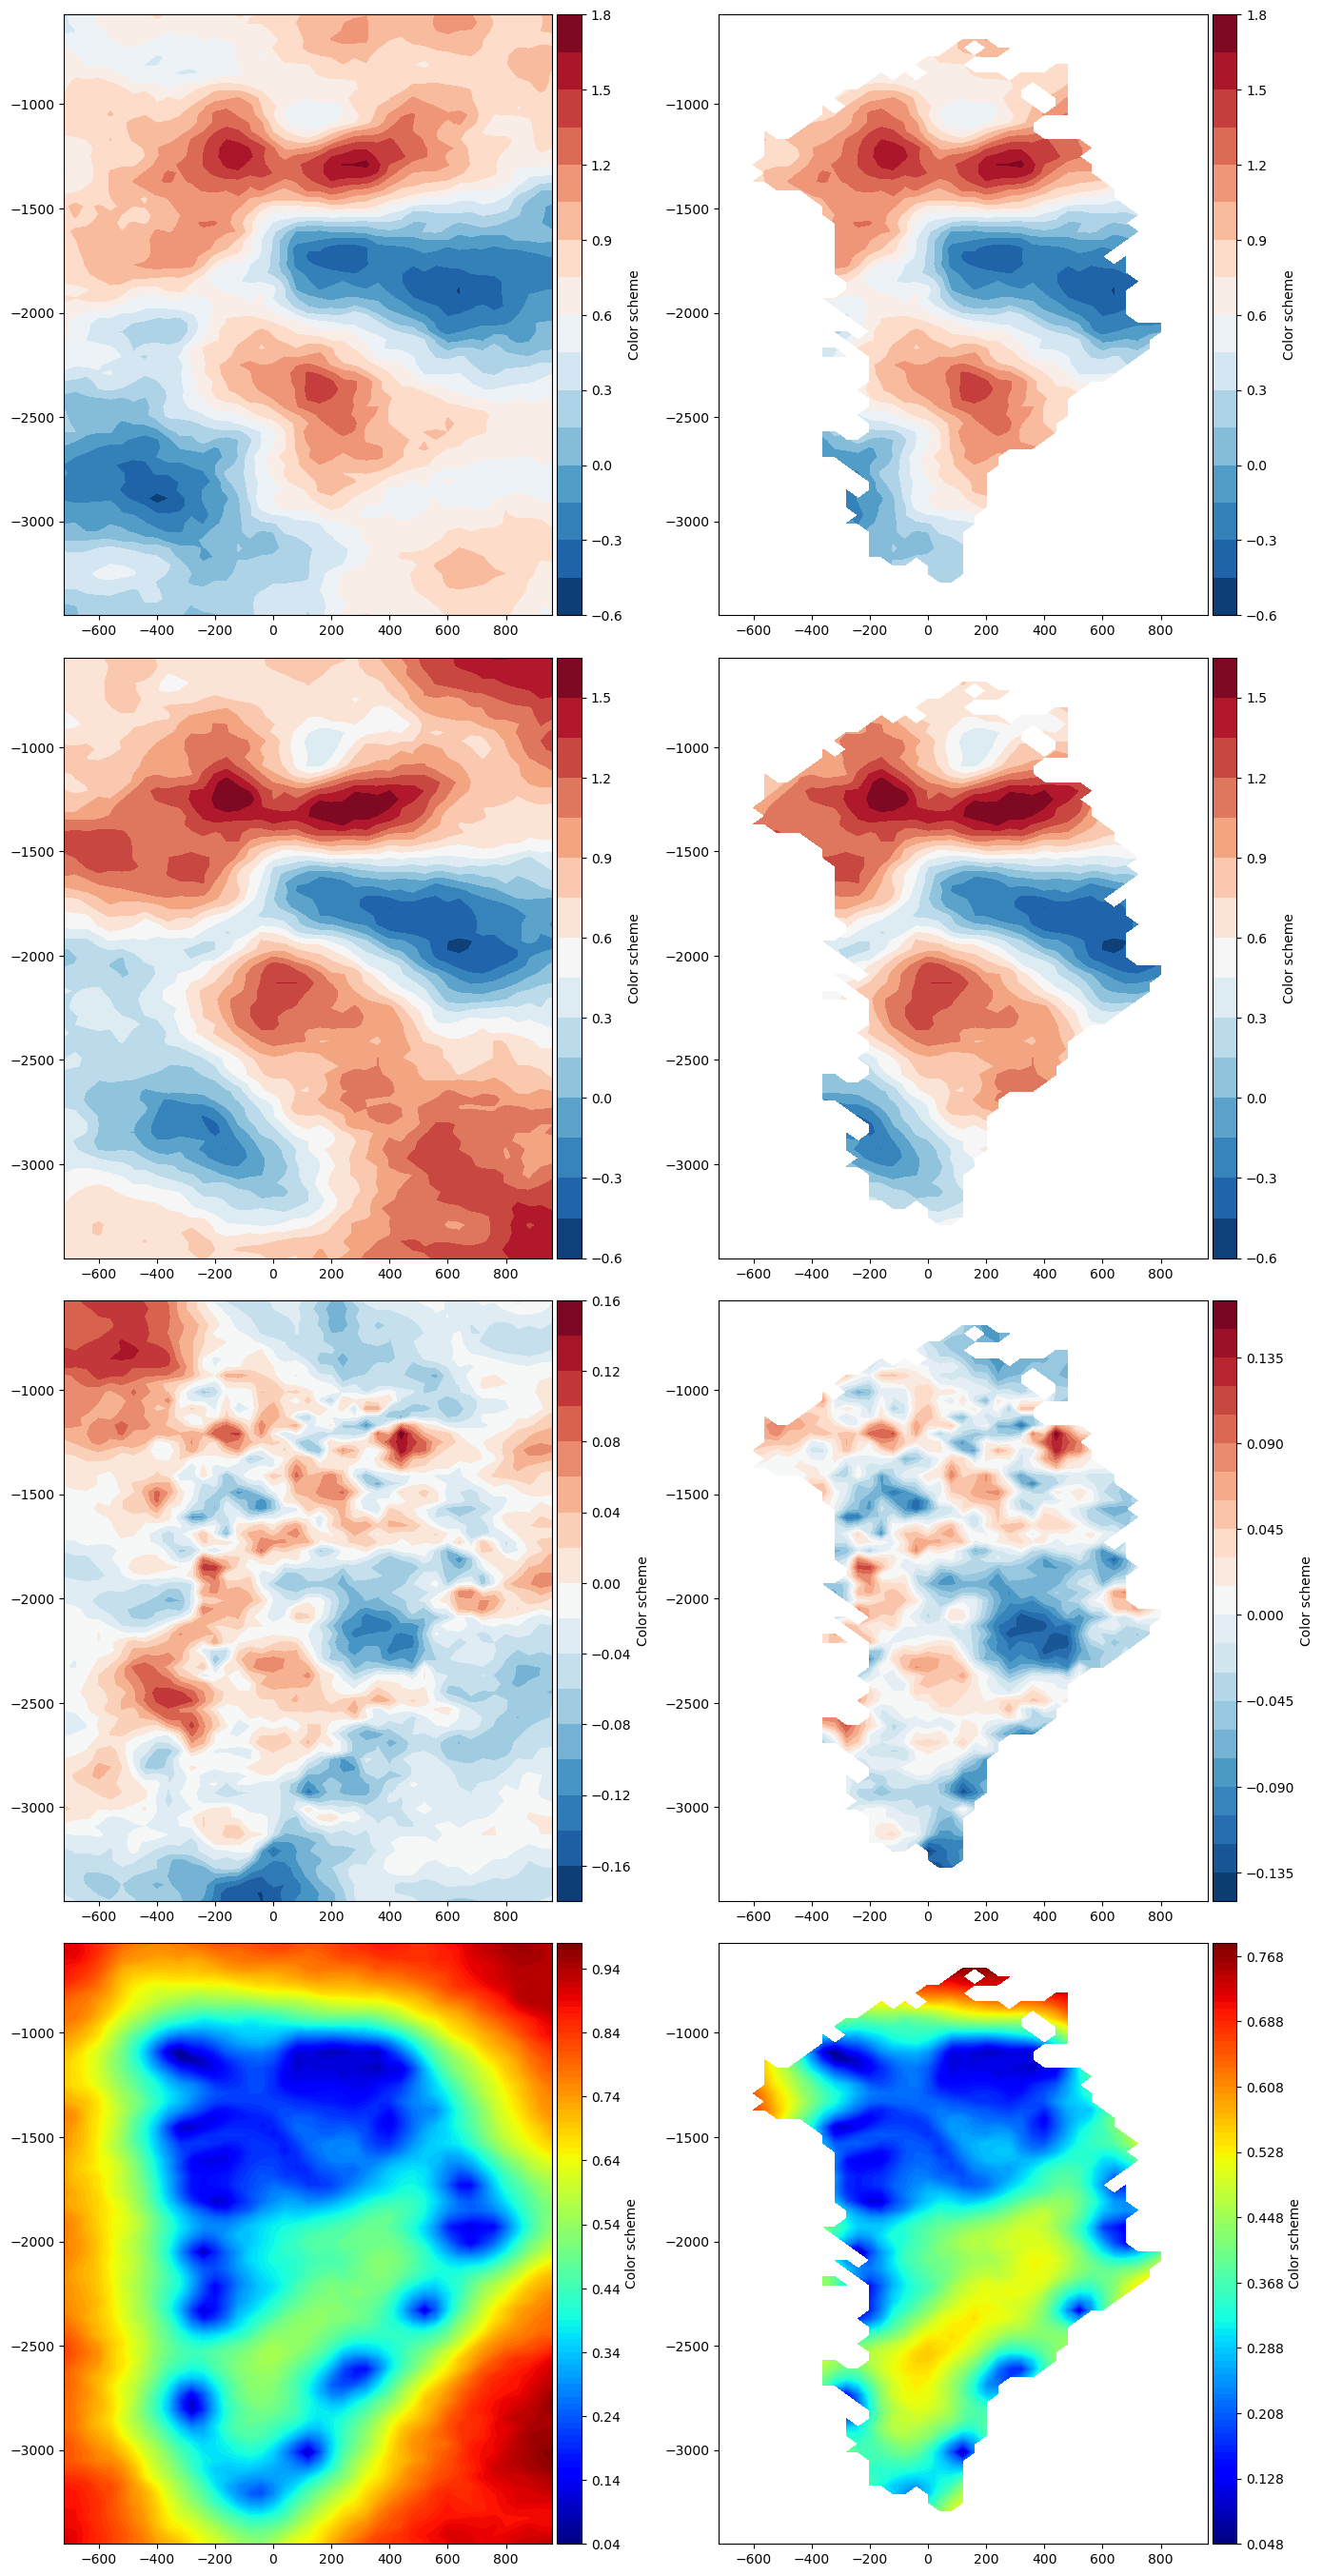

In [22]:
ds_subset_sample_posterior_1 = DA.sample_posterior(U_misfit_dp, Lambda_misfit_dp)
ds_subset_sample_posterior_2 = DA.sample_posterior(U_misfit_dp, Lambda_misfit_dp)
ds_mean_samples_posterior, ds_std_samples_posterior = DA.pointwise_marginals("posterior", 500, U_misfit_dp, Lambda_misfit_dp)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

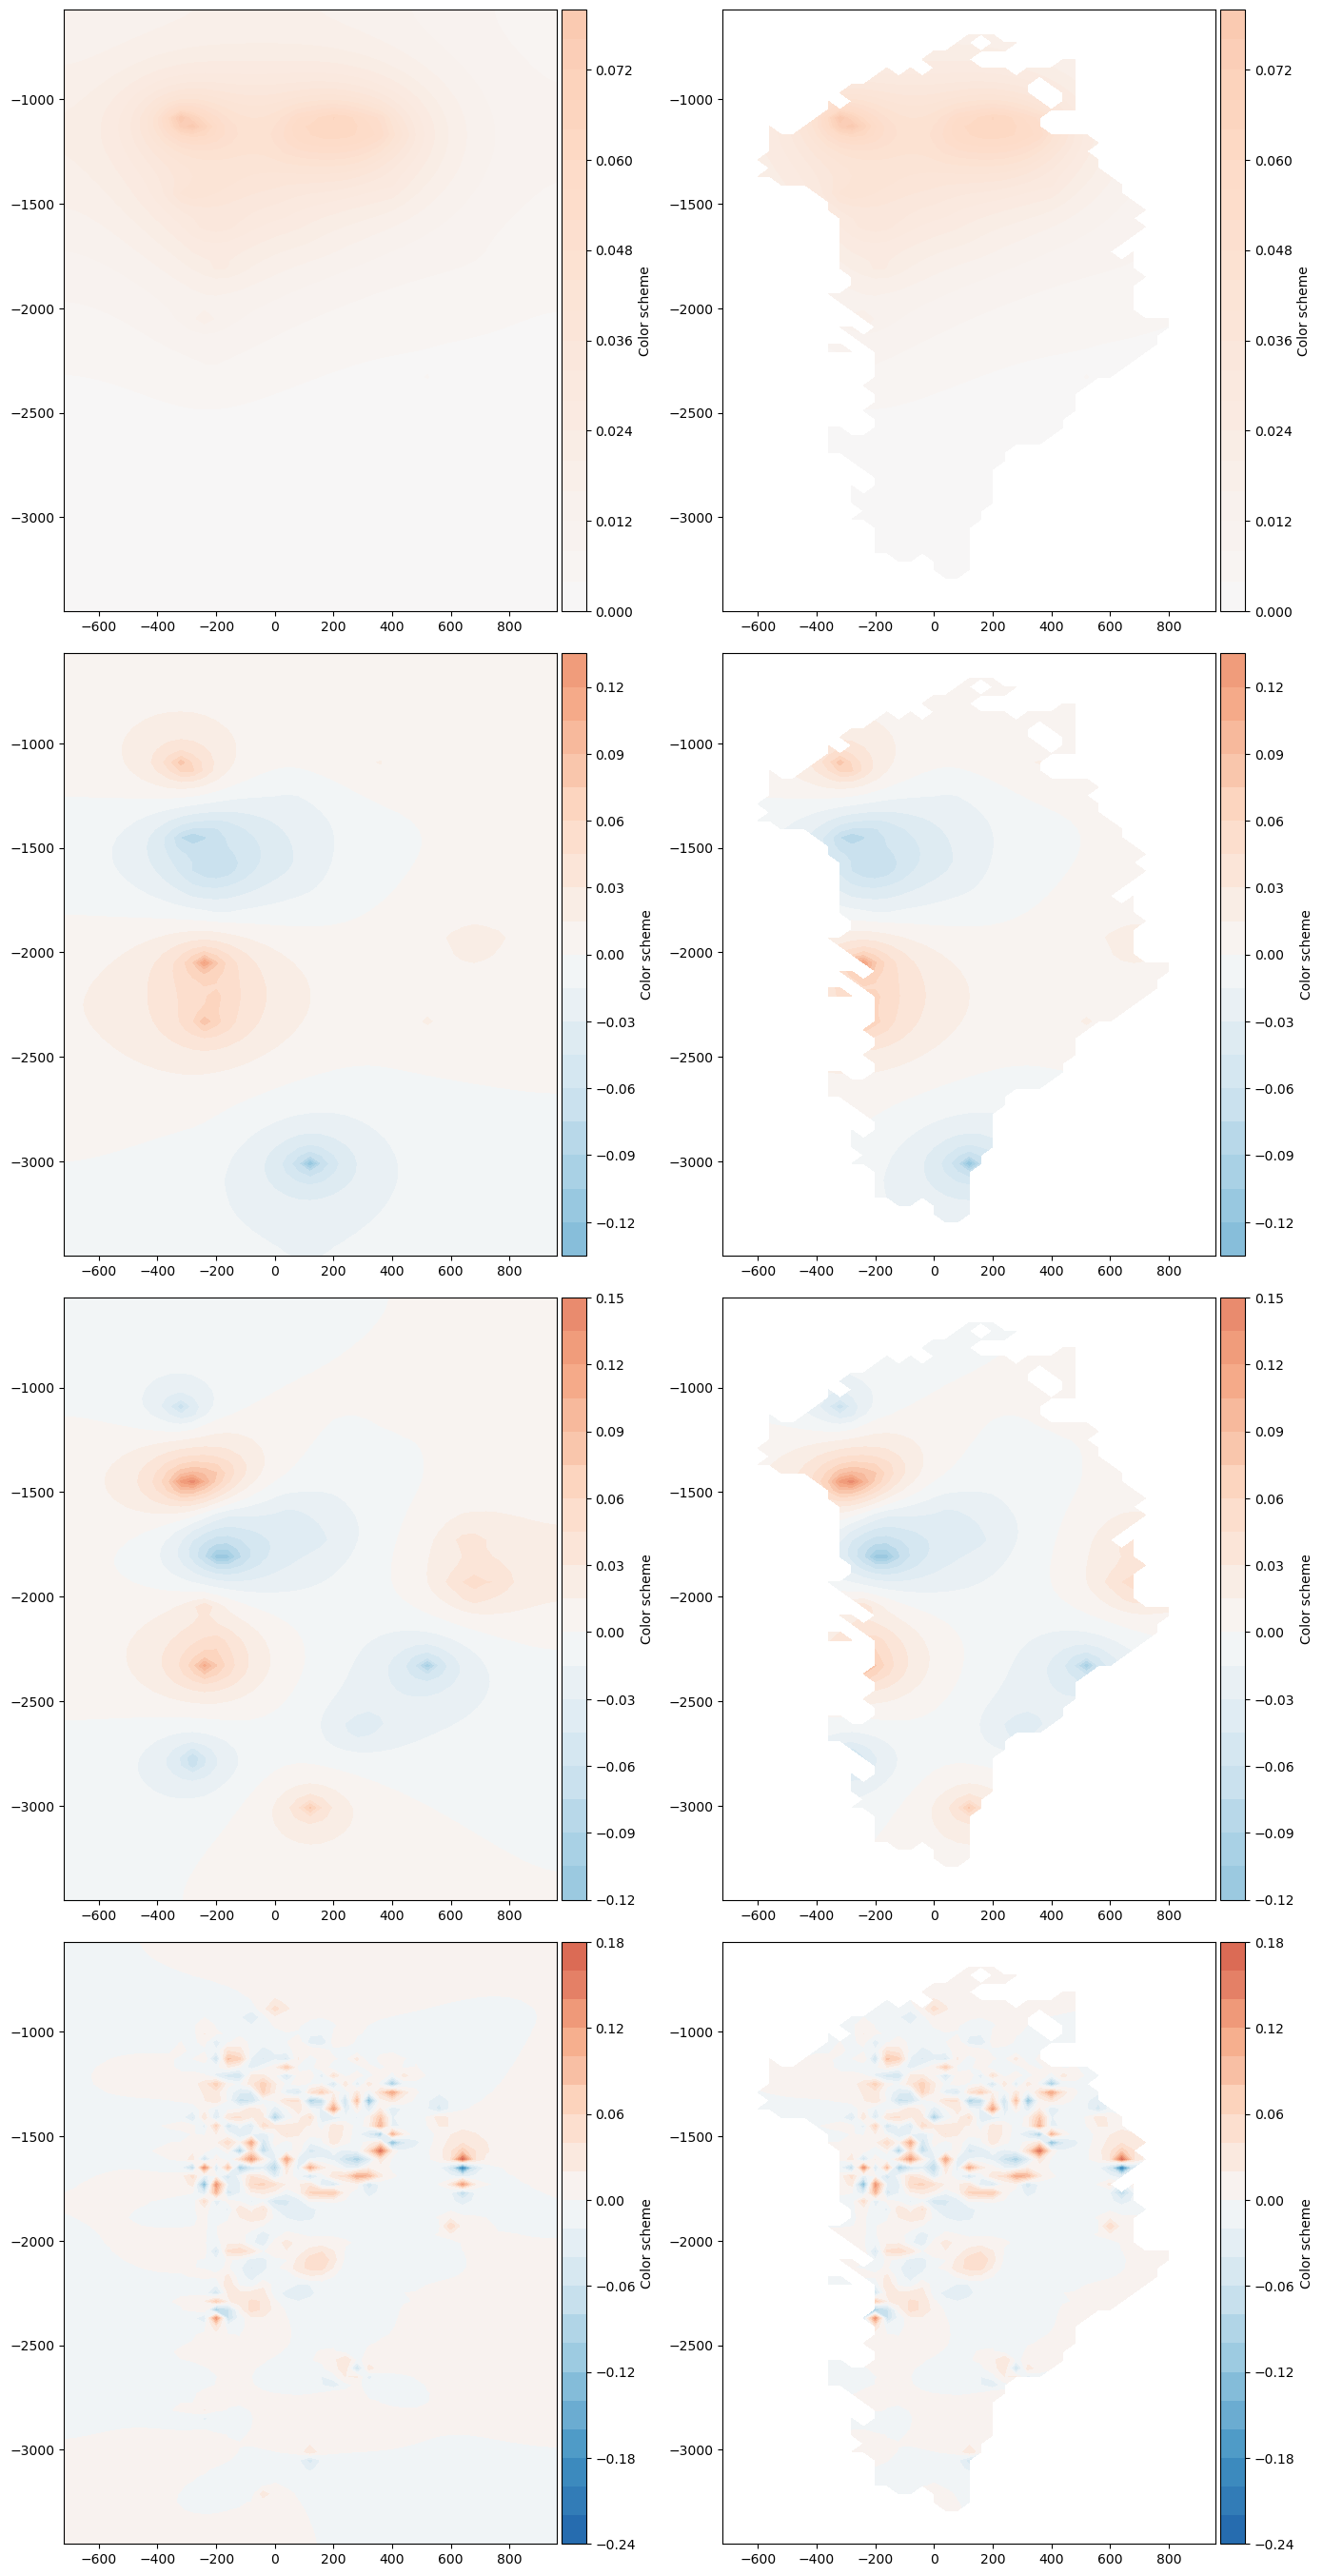

In [23]:
U_misfit_sa_reshaped = np.reshape(U_misfit_sa, (73, 43, -1))

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_sa_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
plt.tight_layout()

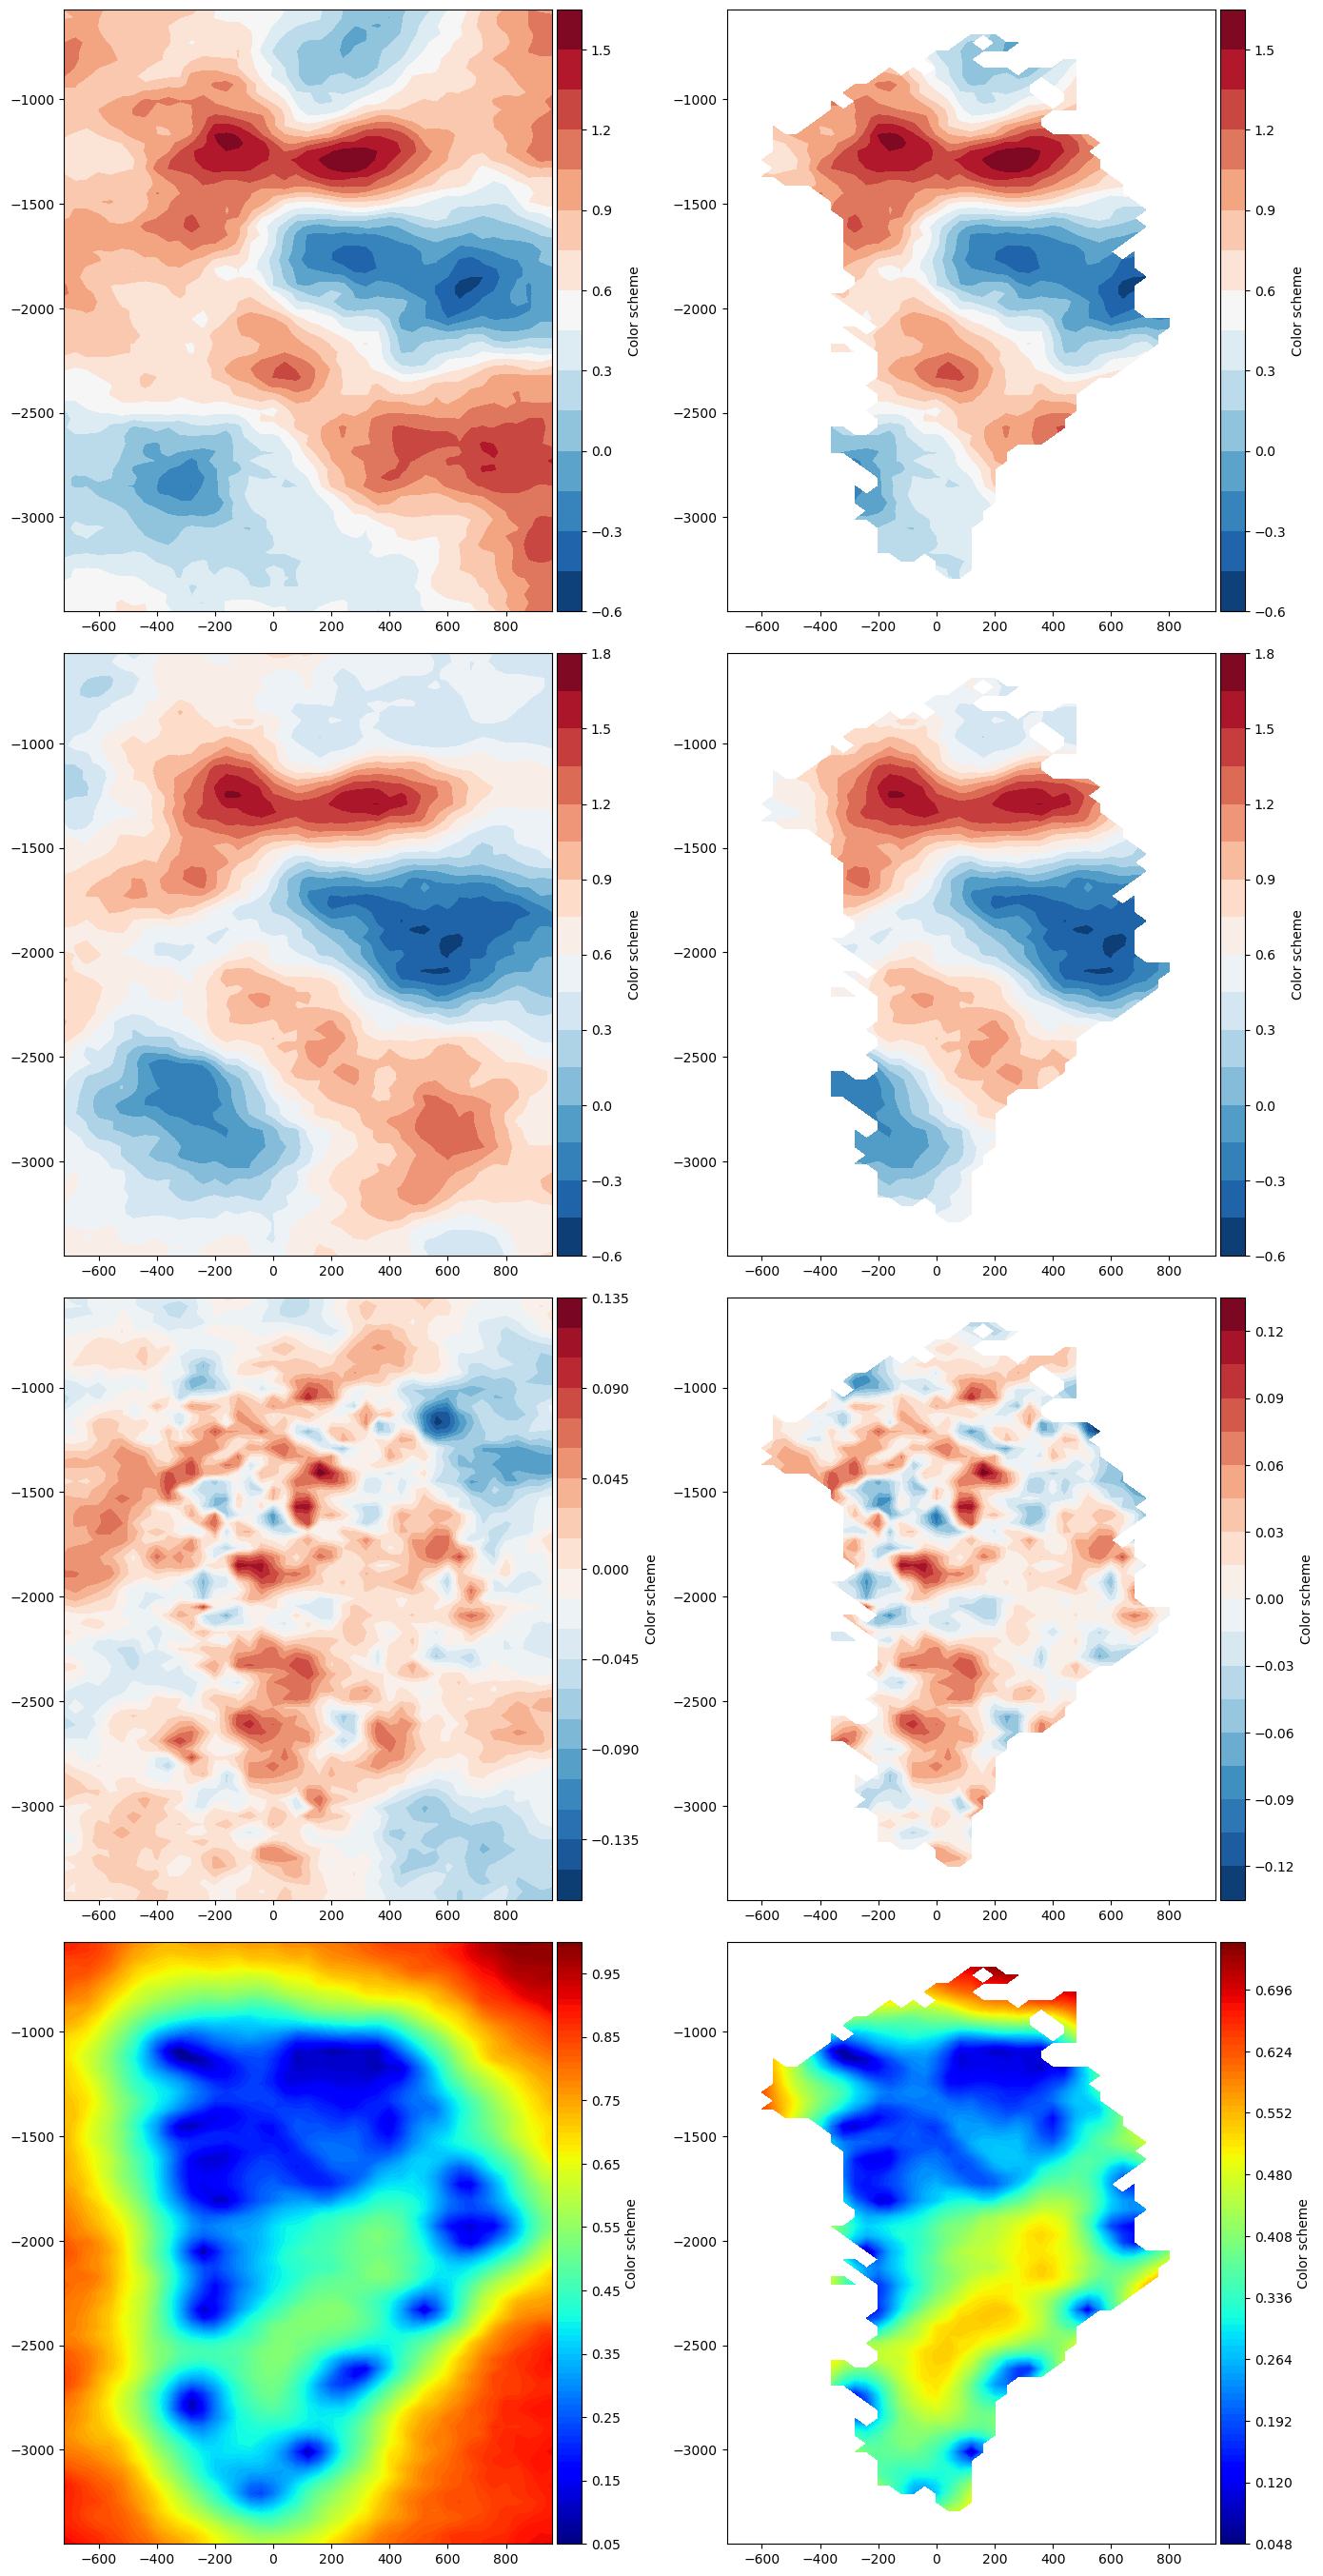

In [24]:
ds_subset_sample_posterior_1 = DA.sample_posterior(U_misfit_sa, Lambda_misfit_sa)
ds_subset_sample_posterior_2 = DA.sample_posterior(U_misfit_sa, Lambda_misfit_sa)
ds_mean_samples_posterior, ds_std_samples_posterior = DA.pointwise_marginals("posterior", 500, U_misfit_sa, Lambda_misfit_sa)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [25]:
# DA = optim.DataAssimilation(sicopolis_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", None, ds_prior_X)

# DA.l_bfgs(5, 3)